## Progenitor cell trajectories

In [4]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scvelo as scv

In [5]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/myeloid_trajectories/"
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [6]:
## Load existing annotation
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) # final annotations and removed maternal contaminant cells

## Load annotation groups
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [412]:
# update_MEP = pd.read_csv('/lustre/scratch117/cellgen/team205/cs42/panfetal/MEP_annotation_change.csv', index_col=0)
# obs.loc[update_MEP.index, 'anno_lvl_2_final_clean'] = update_MEP['anno_lvl_2_final_clean'].copy()
# obs.to_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv')

In [7]:
import rpy2.rinterface_lib.callbacks
import logging

In [8]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [9]:
%load_ext rpy2.ipython

In [360]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

### Read data

In [34]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
spl = 'HSC_IMMUNE'
adata = sc.read_h5ad(data_dir + f"PAN.A01.v01.entire_data_normalised_log.20210429.{spl}.h5ad")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [35]:
figdir = '/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir
scv.settings.figdir = figdir

In [36]:
progenitor_groups = {
    'HSC_MPP_LMP':["HSC_MPP", "CYCLING_MPP", "LMPP_MLP"],
    'T_prog':["DN(early)_T","DN(Q)_T", "DN(P)_T"],
    'B_prog' :['PRE_PRO_B', 'PRO_B','LATE_PRO_B','LARGE_PRE_B','SMALL_PRE_B'],
    'MEM_prog' : ['MEMP', 'CYCLING_MEMP', 'MEP', "EARLY_MK"],
    'MYE_prog' : ['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE'],
    }
progenitor_groups_rev = {x:g for g,a in progenitor_groups.items() for x in a}

In [37]:
## Filter out maternal contaminants
adata = adata[adata.obs_names.isin(obs.index)].copy()

In [38]:
adata.obs = obs.loc[adata.obs_names].copy()
adata.obs['annotation_obs'] = adata.obs['anno_lvl_2_final_clean'].copy()

In [39]:
## Subset to progenitors
adata = adata[adata.obs['annotation_obs'].isin(progenitor_groups_rev.keys())].copy()

## Save pseudobulks for DE analysis
see `<Rmd notebook>`

In [20]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.io
import gzip
import shutil

def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts)
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]
    return(pseudobulk_adata)

In [17]:
adata.obs['prog_lineage'] = [progenitor_groups_rev[x] for x in adata.obs['annotation_obs'] ]

In [21]:
pbulk_adata = anndata2pseudobulk(adata, ["Sample", "donor", "organ", "prog_lineage", "age", "method"]).copy()

In [26]:

def zip_file(indir, filename):
    with open(os.path.join(indir,filename),'rb') as f_in:
        with gzip.open(os.path.join(indir,filename) + '.gz','wb') as f_gz:
            shutil.copyfileobj(f_in, f_gz)
    os.remove(os.path.join(indir,filename)) 

def save_4_de(adata, adata_id, covs=["Sample", "donor", "organ", "anno_lvl_2", "age", "method"]):
    input_data_dir = "/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_{id}/".format(id=adata_id)
    if not os.path.exists(input_data_dir):
        os.mkdir(input_data_dir)
    # Save log-counts matrix
    scipy.io.mmwrite(input_data_dir + "matrix.mtx", adata.X)
    zip_file(input_data_dir, 'matrix.mtx')
    # Save gene names
    adata.var.to_csv(input_data_dir + 'gene.csv')
    zip_file(input_data_dir, 'gene.csv')
    # Save metadata
    lmm_metadata = adata.obs[covs]
    lmm_metadata.to_csv(input_data_dir + 'metadata.csv')
    zip_file(input_data_dir, 'metadata.csv')
    
adata_id =  "PROGENITORS_PBULK"
save_4_de(pbulk_adata, adata_id, covs=["Sample", "donor", "organ", "prog_lineage", "age", "method", "n_cells"])

### CellRank analysis

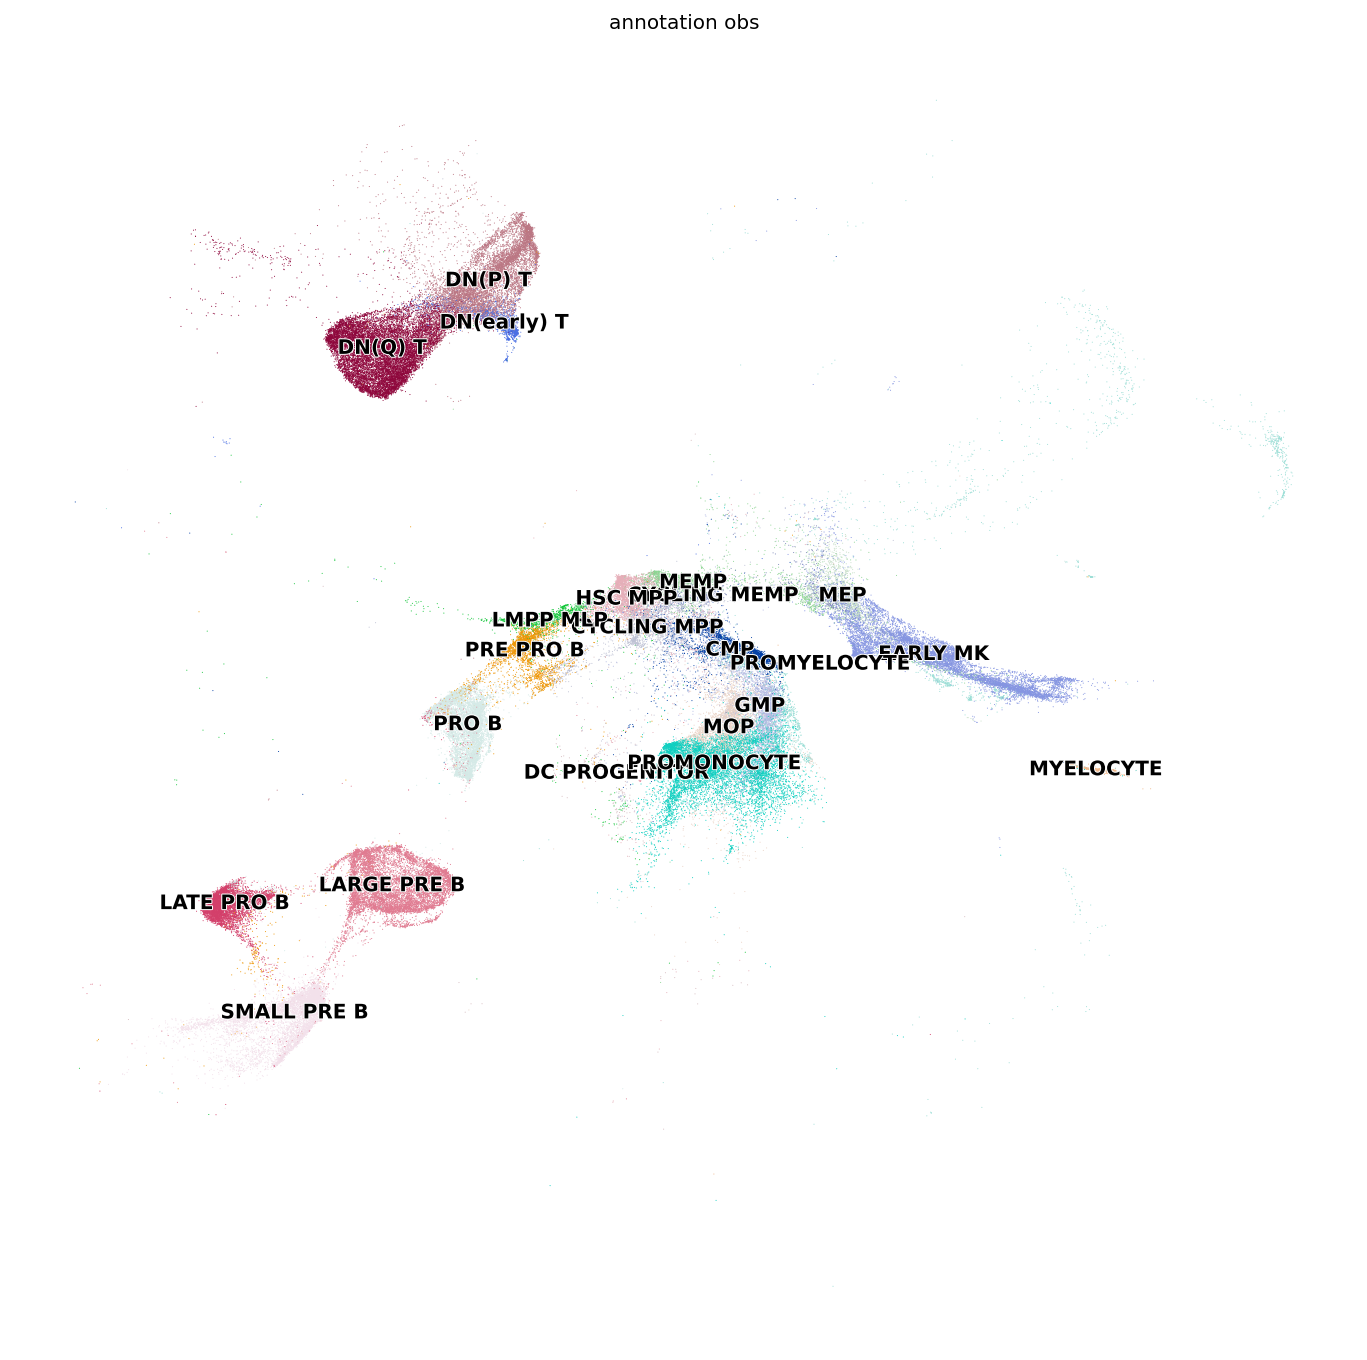

In [63]:
plt.rcParams['figure.figsize'] = [12,12]
scv.pl.umap(adata, color='annotation_obs')

In [64]:
sc.pp.neighbors(adata, use_rep='X_scvi', n_neighbors=30)

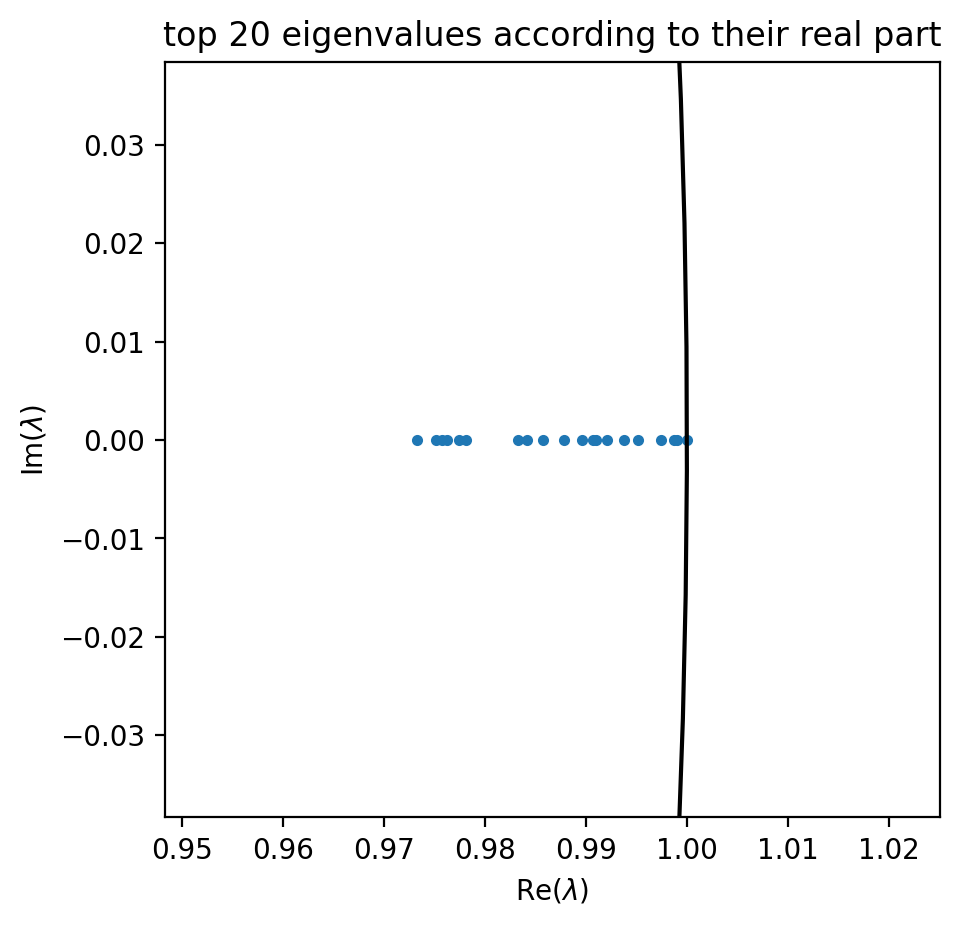

In [65]:
import cellrank as cr
from cellrank.tl.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()
g = cr.tl.estimators.GPCCA(ck)
g.compute_schur(n_components=20)
g.plot_spectrum()

In [66]:
g.compute_macrostates(n_states=15, cluster_key="annotation_obs")

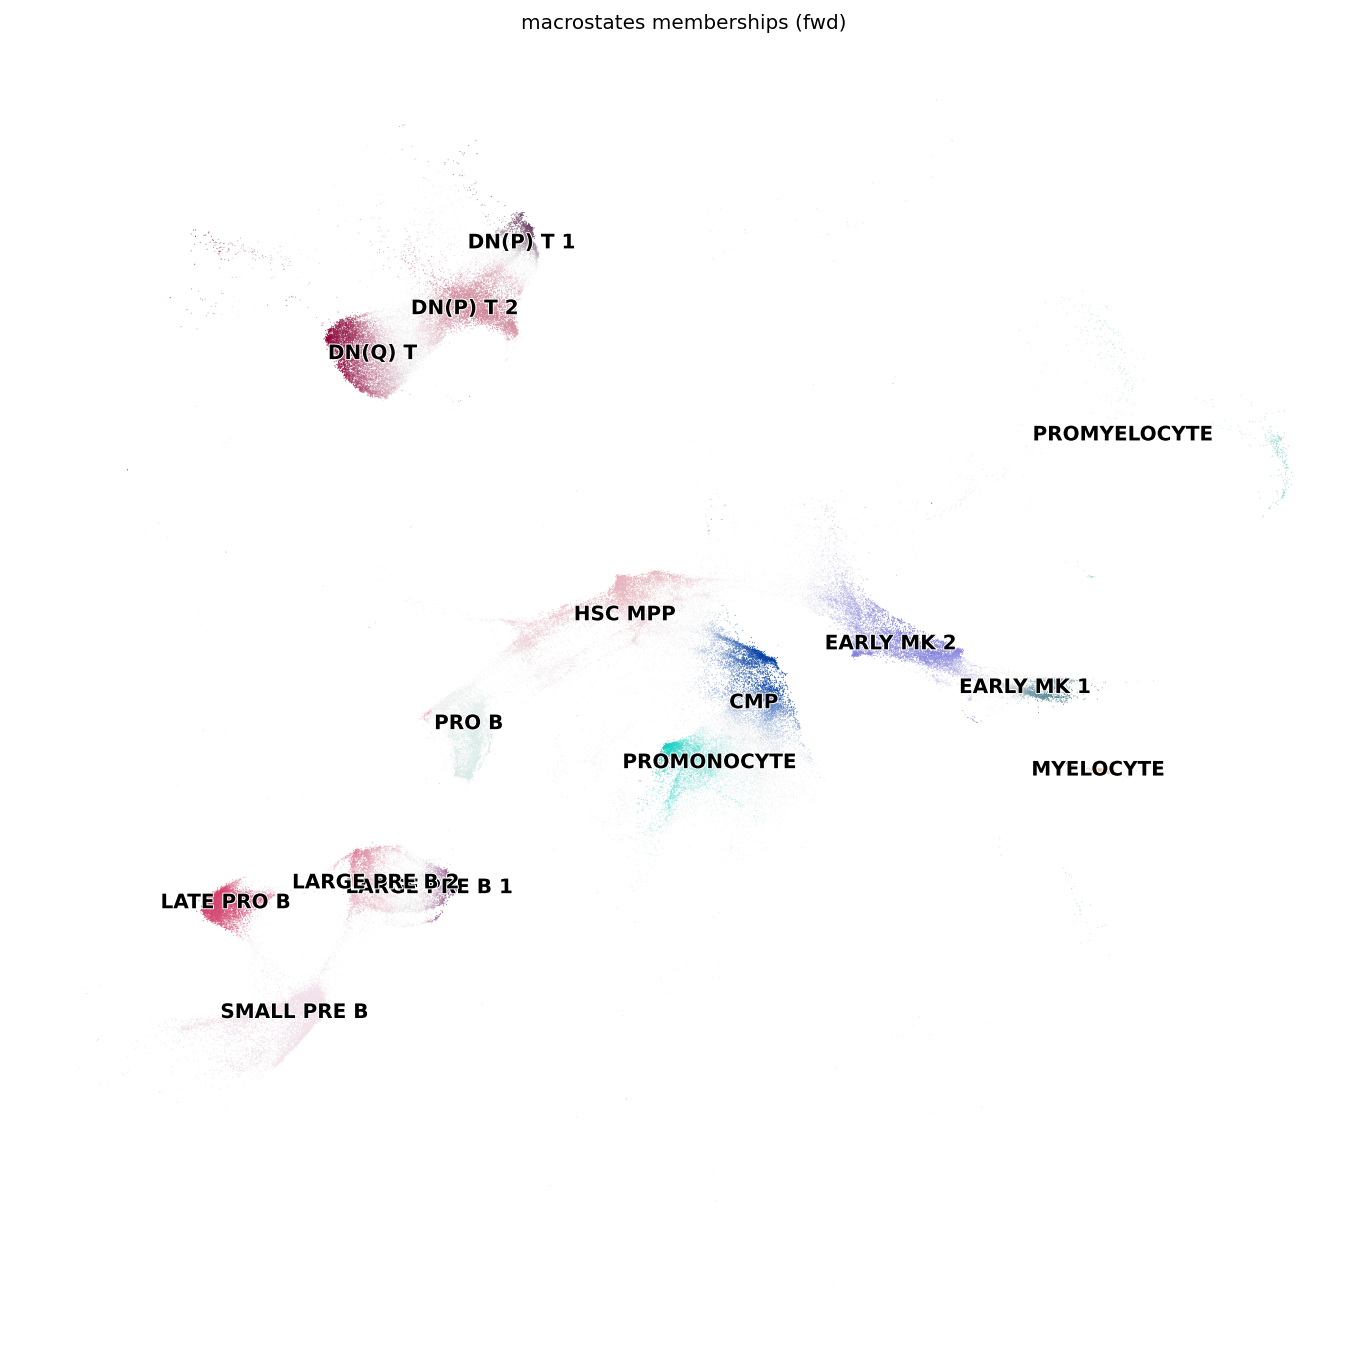

In [67]:
g.plot_macrostates()

In [68]:
g.set_terminal_states_from_macrostates(["SMALL_PRE_B", 'DN(Q)_T', "EARLY_MK_2, EARLY_MK_1", "PROMONOCYTE"])
g.compute_absorption_probabilities()

  0%|          | 0/120 [00:00<?, ?/s]

In [69]:
adata.obsm['to_terminal_states'].names

array(['SMALL_PRE_B', 'DN(Q)_T', 'EARLY_MK_1 or EARLY_MK_2',
       'PROMONOCYTE'], dtype='<U24')

In [70]:
new_names =  {
      'EARLY_MK_1 or EARLY_MK_2':"Megakaryocyte/\nErythroid lineage",
      'PROMONOCYTE':"Myeloid\nlineage",
      'SMALL_PRE_B':"B cells\nlineage",
      'DN(Q)_T':"T cells\nlineage"
  }
adata.obsm['to_terminal_states'].names = [new_names[x] for x in adata.obsm['to_terminal_states'].names]

In [71]:
cr.settings.figdir = figdir

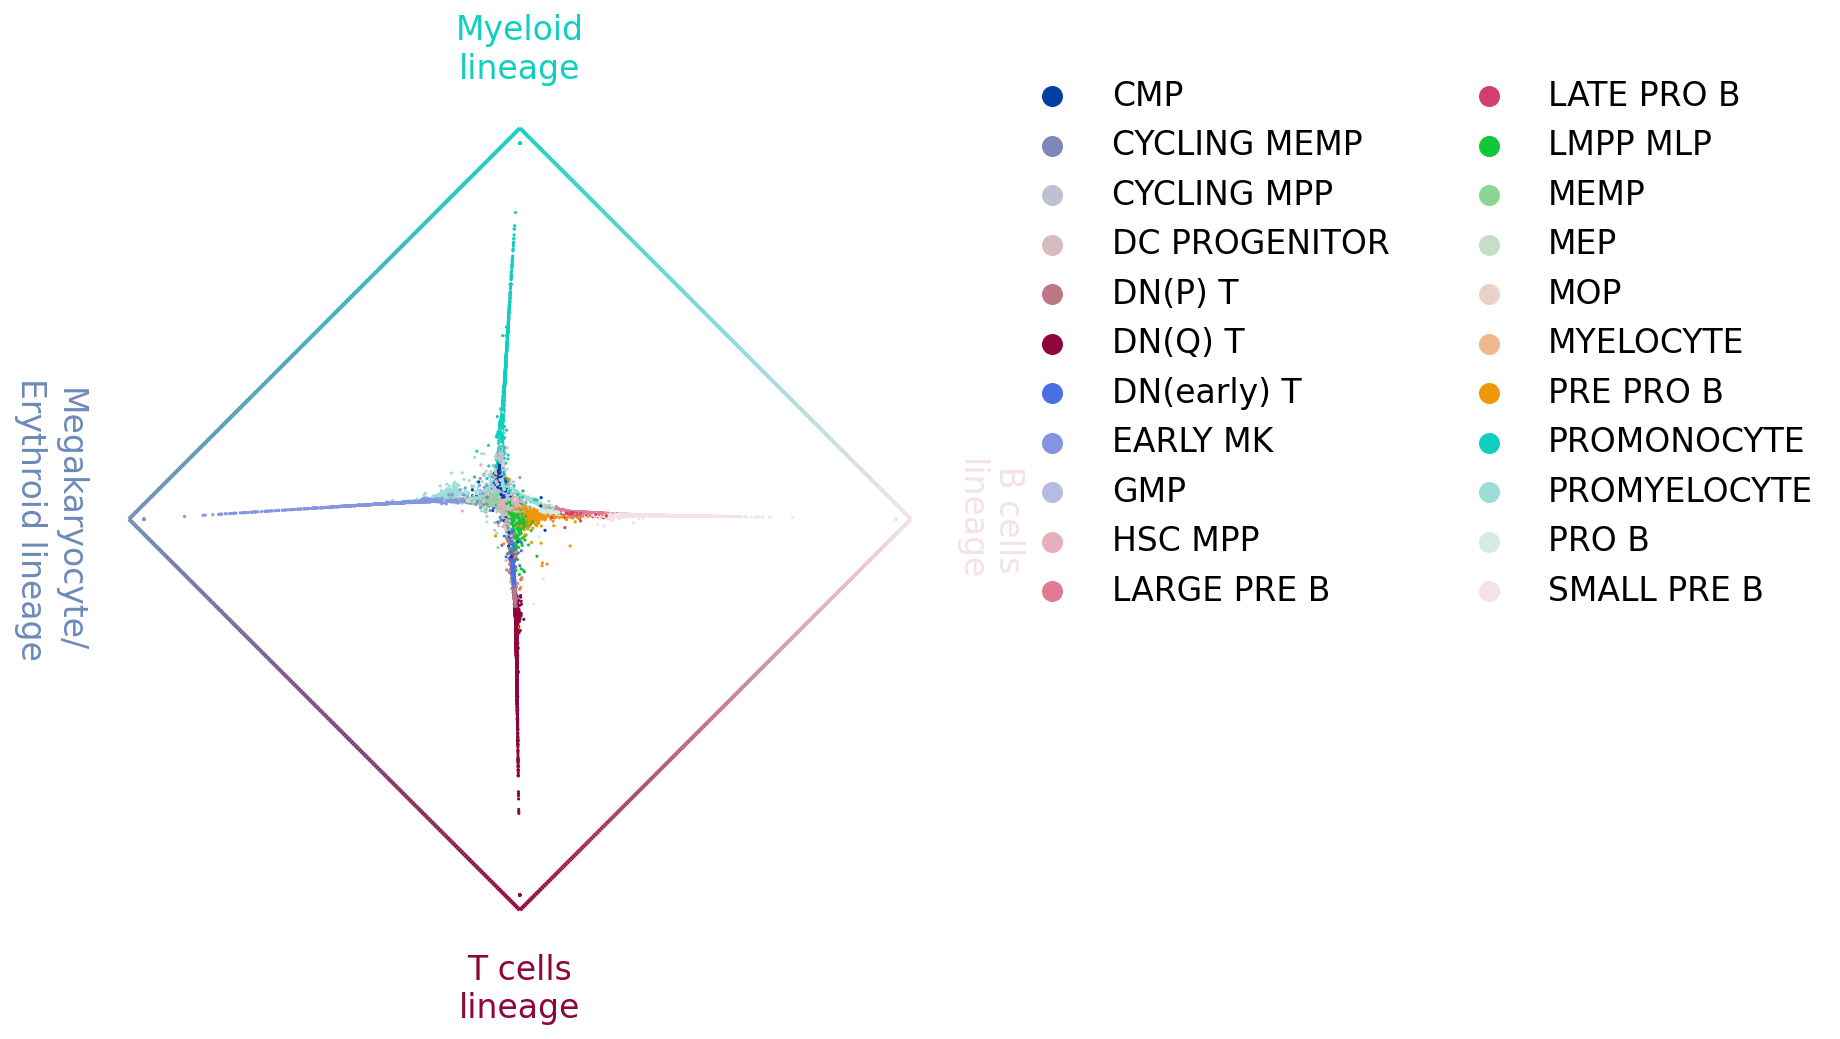

In [72]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_context('talk')
cr.pl.circular_projection(
    adata, keys=["annotation_obs"], legend_loc="upper right", figsize=(40,40), size=10, title='',
    save=figdir+'progenitor_lineages_full.png'
    )

In [73]:
lin_df = pd.DataFrame(adata.obsm['to_terminal_states'].X, columns=[x + "_fate" for x in adata.obsm['to_terminal_states'].names])
lin_df.index = adata.obs_names

In [74]:
if any([x in adata.obs.columns for x in lin_df.columns]):
    adata.obs = adata.obs.drop(lin_df.columns, 1)
adata.obs = pd.concat([adata.obs, lin_df], 1)

In [75]:
simplex_df = pd.DataFrame(adata.obsm['X_fate_simplex_fwd'], columns=['simplex_x','simplex_y'])
simplex_df.index = adata.obs_names

In [76]:
pl_df = adata.obs[lin_df.columns.tolist() + ["organ", 'anno_lvl_2_final_clean'] ].copy()
pl_df = pd.concat([pl_df, simplex_df], 1)

In [77]:
pl_df['prog_group'] = [progenitor_groups_rev[x] if x in progenitor_groups_rev.keys() else  "HSC_MPP_LMP" for x in pl_df['anno_lvl_2_final_clean']]

In [78]:
%%R -i pl_df
head(pl_df)

                                B cells\nlineage_fate T cells\nlineage_fate
FCAImmP7579224-CTAATGGCACTGTGTA             0.4495047             0.1854231
FCAImmP7579224-ATCACGATCACGATGT             0.2639054             0.1751502
FCAImmP7579224-AACTTTCCAGGAATCG             0.2698924             0.1790586
FCAImmP7579224-CGACCTTTCCAAGCCG             0.2880090             0.1966817
FCAImmP7579224-CTCTACGGTCCATCCT             0.2656613             0.1783451
FCAImmP7579224-TGACTAGAGGTGCTTT             0.2848071             0.1940642
                                Megakaryocyte/\nErythroid lineage_fate
FCAImmP7579224-CTAATGGCACTGTGTA                              0.1671311
FCAImmP7579224-ATCACGATCACGATGT                              0.1866983
FCAImmP7579224-AACTTTCCAGGAATCG                              0.1900148
FCAImmP7579224-CGACCTTTCCAAGCCG                              0.2781480
FCAImmP7579224-CTCTACGGTCCATCCT                              0.3350943
FCAImmP7579224-TGACTAGAGGTGCTTT           

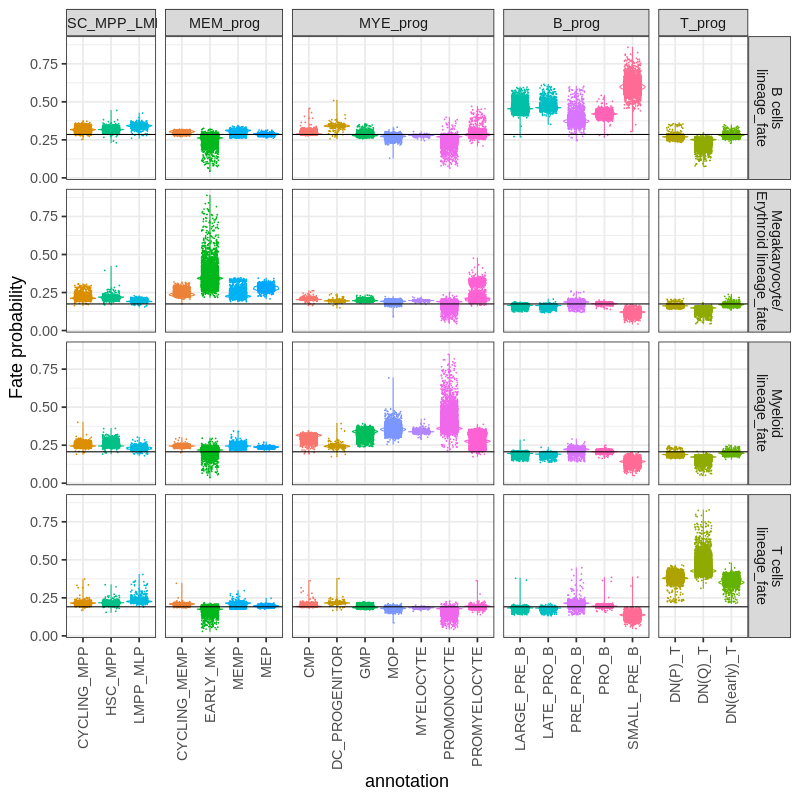

In [80]:
%%R -w 800 -h 800 -i figdir
org_colors <- read.csv("../../metadata/organ_colors.csv")
org_colors <- setNames(org_colors$color, org_colors$organ)

fate_names <- list(
  'EARLY_MK or MEP_fate'="Megakaryocyte/\nErythroid lineage",
  'PROMONOCYTE_fate'="Myeloid\nlineage",
  'PRE_PRO_B_fate'="B cells\nlineage",
  'DN(P)_T_fate'="T cells\nlineage"
)

# fate_labeller <- function(variable,value){
#   return(fate_names[value])
# }

lineage_names <- list(
        'HSC_MPP_LMP'="HSC/MPP/LMP",
  'MEM_prog'="Megakaryocyte/\nErythroid",
  'MYE_prog'="Myeloid",
  'B_prog'="B cells",
  'T_prog'="T cells"
)

lineage_labeller <- function(variable,value){
  return(lineage_names[value])
}

pl_df %>%
    pivot_longer(cols = - c(organ, simplex_x, simplex_y, anno_lvl_2_final_clean, prog_group), names_to='terminal_state', values_to='fate_probability') %>%
    filter(fate_probability < 1 & fate_probability > 0) %>%
    group_by(terminal_state, anno_lvl_2_final_clean) %>%
    mutate(mean_prob = max(fate_probability)) %>%
    ungroup() %>%
    group_by(terminal_state) %>%
    mutate(rank=dense_rank(-mean_prob)) %>%
    ungroup() %>%
    mutate(prog_group=factor(prog_group, levels=c("HSC_MPP_LMP", "MEM_prog", "MYE_prog", "B_prog", "T_prog"))) %>%
    ggplot(aes(anno_lvl_2_final_clean, fate_probability, color=anno_lvl_2_final_clean)) +
    geom_violin(scale='width') +
    geom_jitter(size=0.2, width=0.3) +
    geom_hline(data=. %>% group_by(terminal_state) %>% summarise(fate_probability=median(fate_probability)), aes(yintercept=fate_probability))  +
    facet_grid(terminal_state~prog_group, scales='free_x', space='free', 
#                labeller = labeller(prog_group=as_labeller(lineage_labeller))
              ) +
    theme_bw(base_size=18) +
    xlab("annotation") + ylab("Fate probability") +
    guides(color='none') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
        ggsave(paste0(figdir, 'fate_probability_ct_full.png'), width=10, height=10)

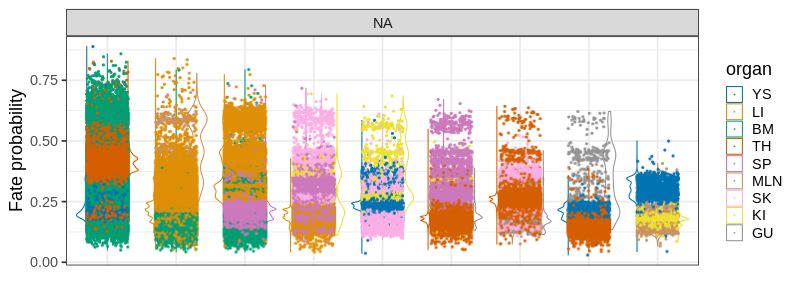

In [81]:
%%R -w 800 -h 300 -i figdir
org_colors <- read.csv("../../metadata/organ_colors.csv")
org_colors <- setNames(org_colors$color, org_colors$organ)

pl_df %>%
    pivot_longer(cols = - c(organ, simplex_x, simplex_y, anno_lvl_2_final_clean, prog_group), names_to='terminal_state', values_to='fate_probability') %>%
    filter(fate_probability < 1 & fate_probability > 0) %>%
    group_by(terminal_state, organ) %>%
    mutate(mean_prob = max(fate_probability)) %>%
    ungroup() %>%
    group_by(terminal_state) %>%
    mutate(rank=dense_rank(-mean_prob)) %>%
    ungroup() %>%
    mutate(terminal_state = factor(terminal_state, levels=unlist(fate_names))) %>%
    mutate(organ=factor(organ, levels=c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU"))) %>%
    ggplot(aes(as.factor(rank), fate_probability, color=organ)) +
    geom_violin(scale='width') +
    ggrastr::rasterise(geom_jitter(size=0.2, width=0.3)) +
#     geom_hline(data=. %>% group_by(terminal_state) %>% summarise(fate_probability=median(fate_probability)), aes(yintercept=fate_probability)) 
    scale_color_manual(values=org_colors) +
    facet_wrap(terminal_state~., ncol=4, scales='free') +
    theme_bw(base_size=18) + 
    xlab('') + ylab("Fate probability") +
    theme(axis.ticks.x=element_blank(), axis.text.x=element_blank()) +
    ggsave(paste0(figdir, 'fate_probability_organ_full.png'), width=10, height=4) +
    ggsave(paste0(figdir, 'fate_probability_organ_full.pdf'), width=10, height=4)

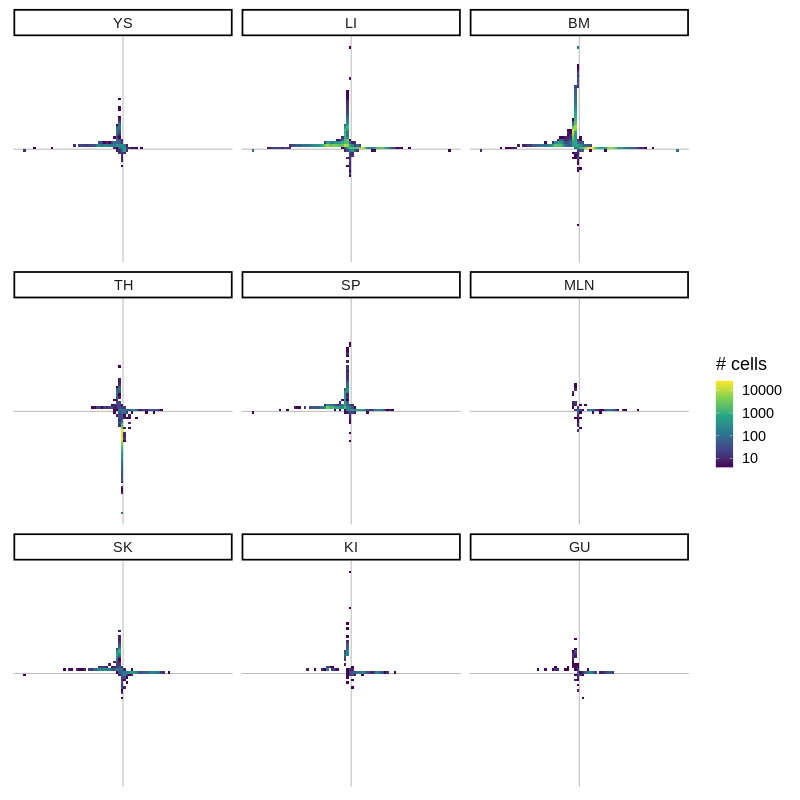

In [82]:
%%R -w 800 -h 800
pl_df %>%
    pivot_longer(cols = - c(organ, simplex_x, simplex_y, anno_lvl_2_final_clean, prog_group), names_to='terminal_state', values_to='fate_probability') %>%
    mutate(organ=factor(organ, levels=c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU"))) %>%
    ggplot(aes(simplex_x, simplex_y)) +
    geom_vline(xintercept=0, color='grey') + geom_hline(yintercept=0, color='grey') +
    geom_bin2d(bins=80) + 
    scale_fill_viridis_c(trans = "log10", name='# cells') +
    facet_wrap(organ~.) +
    theme_classic(base_size=18) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.title.x=element_blank(), axis.line=element_blank(),
         axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()) +
    ggsave(paste0(figdir, 'fate_simplex_organ_full.png'), width=7, height=7) +
    ggsave(paste0(figdir, 'fate_simplex_organ_full.pdf'), width=7, height=7)

### Old vs new annotations

In [46]:
bm_annotations = pd.read_csv('../../metadata/old_annotations/bm_annot.csv', index_col=0)
bm_samples = adata[adata.obs['organ']=='BM'].obs['Sample.lanes'].unique()
keep_ixs_all = []
for s in bm_samples:
    keep_ixs = [x for x in bm_annotations.index if s in x]
    keep_ixs_all.extend(keep_ixs)
bm_annotations = bm_annotations.loc[keep_ixs_all]
bm_annotations.index  = [x[3] + "-" + x[5] for x in bm_annotations.index.str.split('_')]

In [49]:
annotated_cells = adata.obs_names.isin(bm_annotations.index)
new_annot = adata[annotated_cells].obs['annotation_obs']

In [50]:
old_annot = bm_annotations.loc[adata[annotated_cells].obs_names, 'cell.labels']
annot_df = pd.concat([new_annot, old_annot], 1)
annot_df.columns = ['new','old']

In [58]:
sum(adata.obs['organ'] == 'BM')

46448

In [59]:
annotated_cells.sum()

32274

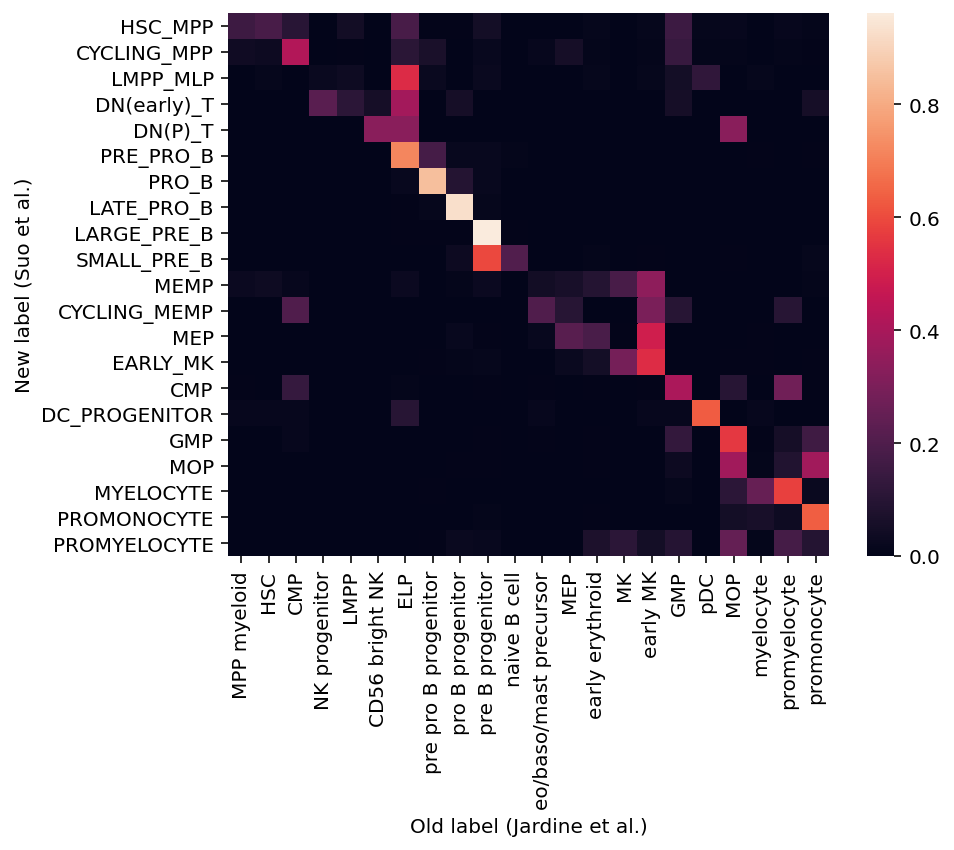

In [57]:
plt.rcParams['figure.figsize'] = [7,6]
conf_mat = sc.metrics.confusion_matrix('new', 'old', data=annot_df, normalize=True)
conf_mat = conf_mat.loc[:,conf_mat.max(0) > 0.1]

conf_mat = conf_mat.loc[[x for x in list(progenitor_groups_rev.keys()) if x in conf_mat.index]].copy()
conf_mat.index = conf_mat.index.astype('category').set_categories(conf_mat.index)
col_max = conf_mat.idxmax(0)
col_max = col_max.astype('category').cat.set_categories(conf_mat.index)
col_order = col_max.sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("Old label (Jardine et al.)");
plt.ylabel("New label (Suo et al.)");
plt.tight_layout();
plt.savefig(figdir + "BM_progenitors_confusion.png")

In [852]:
li_annotations = pd.read_csv('../../metadata/old_annotations/li_annot.csv', index_col=0)
li_samples = adata[adata.obs['organ']=='LI'].obs['Sample.lanes'].unique()
keep_ixs_all = []
for s in li_samples:
    keep_ixs = [x for x in li_annotations.index if s in x]
    keep_ixs_all.extend(keep_ixs)
li_annotations = li_annotations.loc[keep_ixs_all]
li_annotations.index  = [x[3] + '-' + x[4] for x in li_annotations.index.str.split('_')]

In [853]:
annotated_cells = adata.obs_names.isin(li_annotations.index)
new_annot = adata[annotated_cells].obs['anno_lvl_2_final_clean']
old_annot = li_annotations.loc[adata[annotated_cells].obs_names, 'cell.labels']
annot_df = pd.concat([new_annot, old_annot], 1)
annot_df.columns = ['new','old']

In [854]:
annotated_cells.sum()/len(annotated_cells)

0.10466609391310774

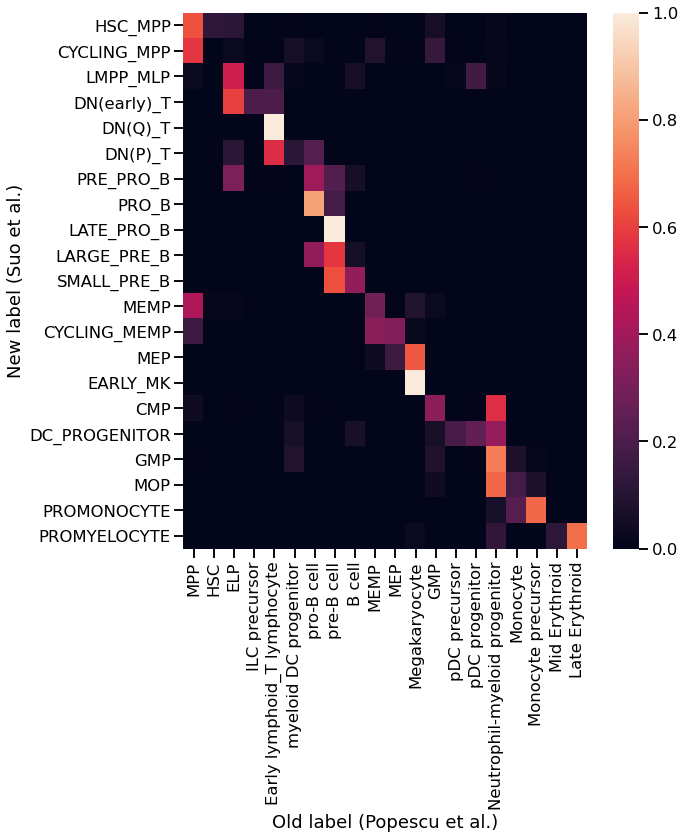

In [845]:
conf_mat = sc.metrics.confusion_matrix('new', 'old', data=annot_df, normalize=True)
conf_mat = conf_mat.loc[:,conf_mat.max(0) > 0.1]

conf_mat = conf_mat.loc[[x for x in list(progenitor_groups_rev.keys()) if x in conf_mat.index]].copy()
conf_mat.index = conf_mat.index.astype('category').set_categories(conf_mat.index)
col_max = conf_mat.idxmax(0)
col_max = col_max.astype('category').cat.set_categories(conf_mat.index)
col_order = col_max.sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("Old label (Popescu et al.)");
plt.ylabel("New label (Suo et al.)");
plt.tight_layout();
plt.savefig(figdir + "LI_progenitors_confusion.png")

## Differential abundance analysis on progenitors

In [112]:
facs_prop_df = pd.read_csv("../../metadata/220621_FACs_gating_proportions_correct.csv")

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

facs_prop_df['file'] = facs_prop_df['Sample.lanes']

In [132]:
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)


In [83]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
spl = 'HSC_PROGENITORS'
adata = sc.read_h5ad(data_dir + f"PAN.A01.v01.raw_count.20210429.HSC_PROGENITORS.embedding.h5ad")
adata.var_names_make_unique()

In [87]:
adata = adata[~adata.obs['is_maternal_contaminant']].copy()

In [106]:
adata

AnnData object with n_obs × n_vars = 40420 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap', 'nhood_neighbors_key'
    obsm: 'X_scvi', 'X_umap', 'nhoods'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [93]:
adata.obs.loc[:,'anno_lvl_2_final_clean'] = obs.loc[adata.obs_names,'anno_lvl_2_final_clean']

### Prep for DA analysis

In [114]:
## Add to obs info about FACS proportions
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names
adata.obs = new_obs.drop("_merge", 1).copy()

In [115]:
## Split gestational age into bins
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]

adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

## Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes

## Keep cd45+, cd45- and unsorted cells
### Fix sort ids
adata.obs["Sort_id"] = ["CD45P" if x == "CD45P_CD45N" else x for x in adata.obs["Sort_id"]]
adata.obs["Sort_id"] = ["CD45N" if x == "CD45EN" else x for x in adata.obs["Sort_id"]]

### Exclude cells from unconventional sorts
adata = adata[adata.obs["Sort_id"].isin(["CD45P", "CD45N", "TOT"])]
### Exclude CD45P/N cells that don't have true fraction quantification (mainly Gut)
adata = adata[~(adata.obs["Sort_id"].isin(["CD45P", "CD45N"]) & adata.obs["sort.ids"].isna())]

In [120]:
import milopy
import milopy.core as milo

In [108]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep = 'X_scvi', key_added = 'scvi')

In [123]:
milo.make_nhoods(adata, neighbors_key='scvi')

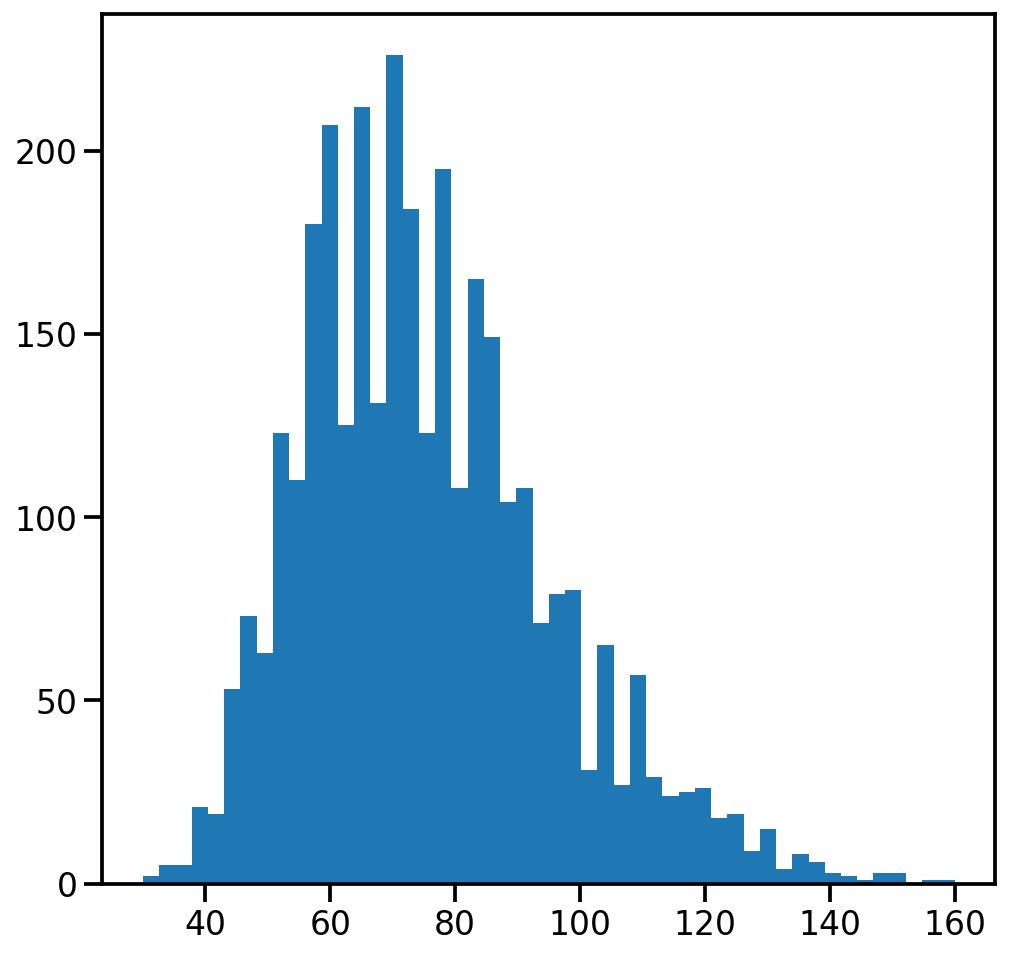

In [124]:
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=50);

In [125]:
## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [133]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["Sort_id"]=="TOT","correction_factor"] = 0

Trying to set attribute `.var` of view, copying.


### Test all organs together

In [135]:
milo.DA_nhoods(adata, design="~ correction_factor + age_bins")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [139]:
milo_res = adata.uns['nhood_adata'].obs.copy()

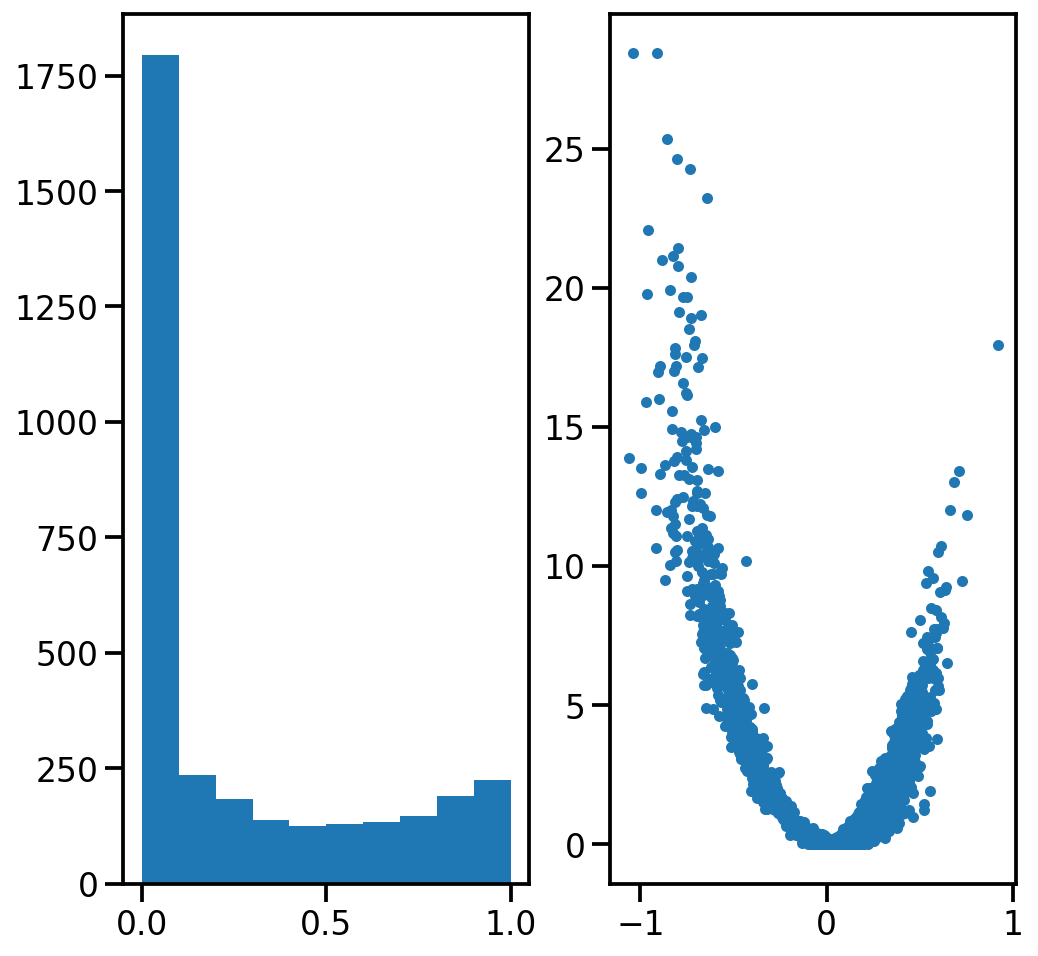

In [144]:
plt.subplot(1,2,1);
plt.hist(milo_res.PValue);
plt.subplot(1,2,2);
plt.plot(milo_res.logFC, - np.log10(milo_res.SpatialFDR), '.')

In [145]:
milopy.utils.build_nhood_graph(adata)

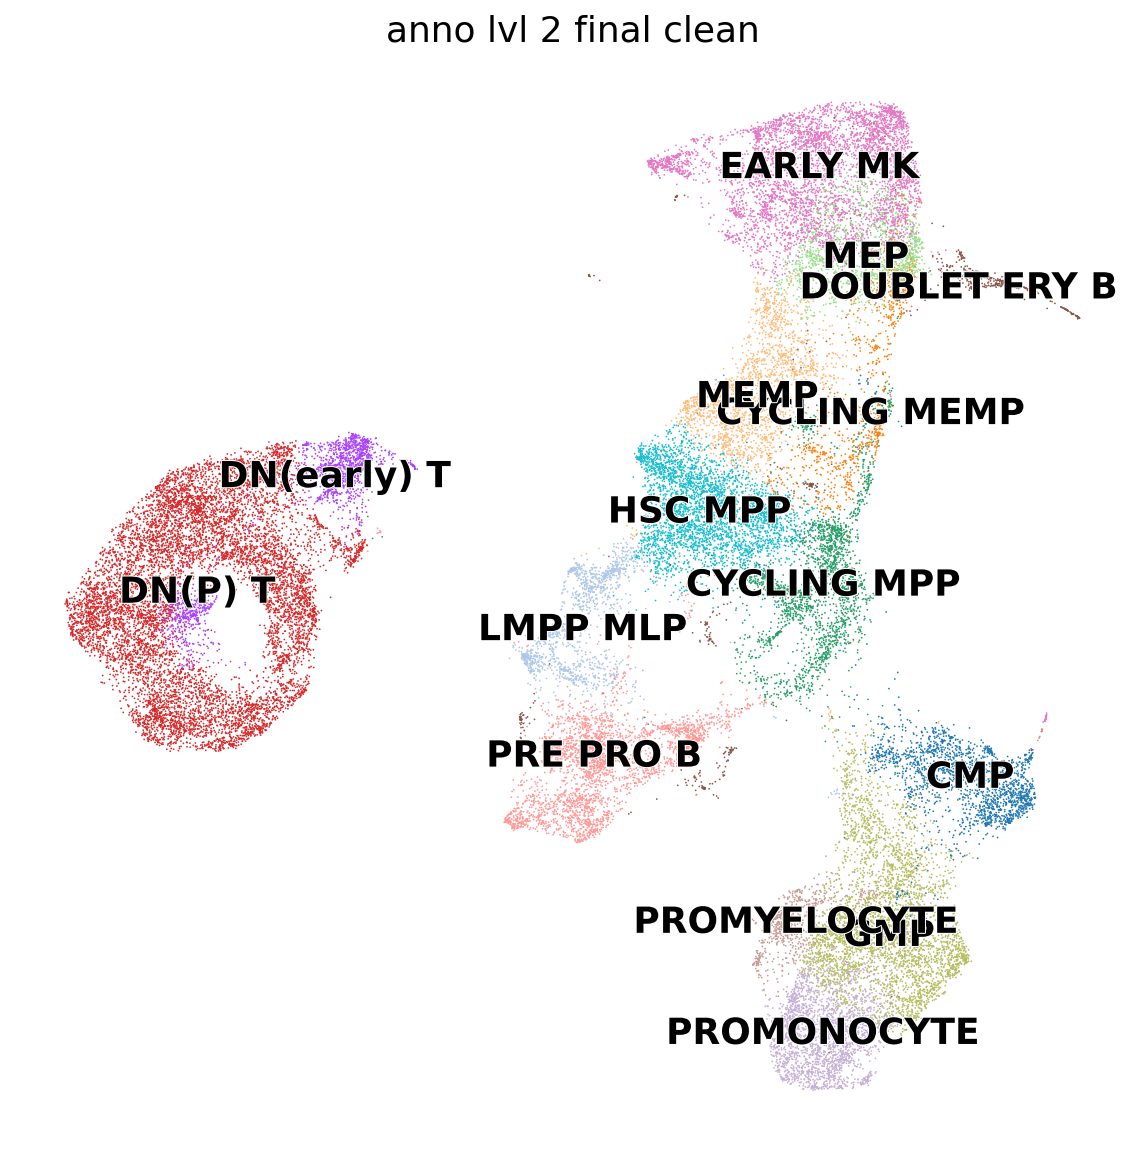

In [409]:
scv.pl.umap(adata, color='anno_lvl_2_final_clean', legend_loc='on data')

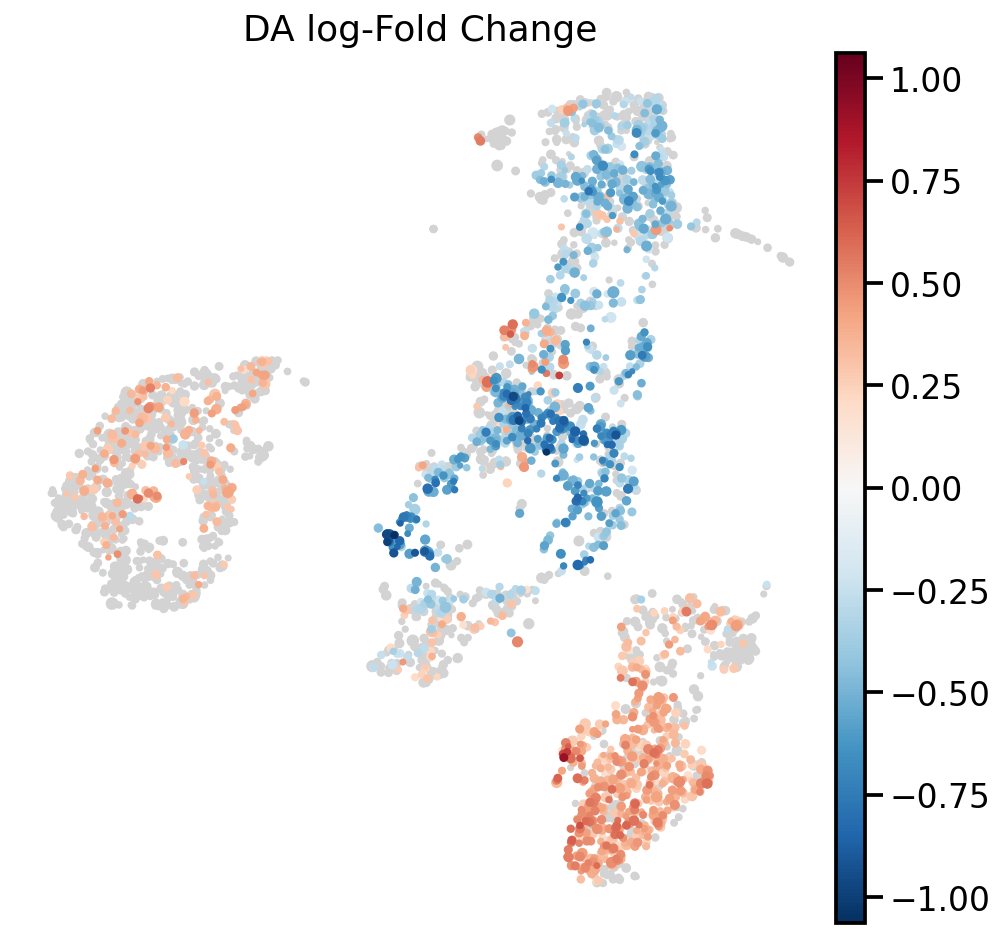

In [147]:
adata.uns['nhood_adata'].obs = milo_res.copy()
adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
milopy.plot.plot_nhood_graph(adata, alpha=0.1, 
                        min_logFC= 0, min_size=1, 
#                         title=org,save='nhood_graph_{o}.pdf'.format(o=org)
                       )

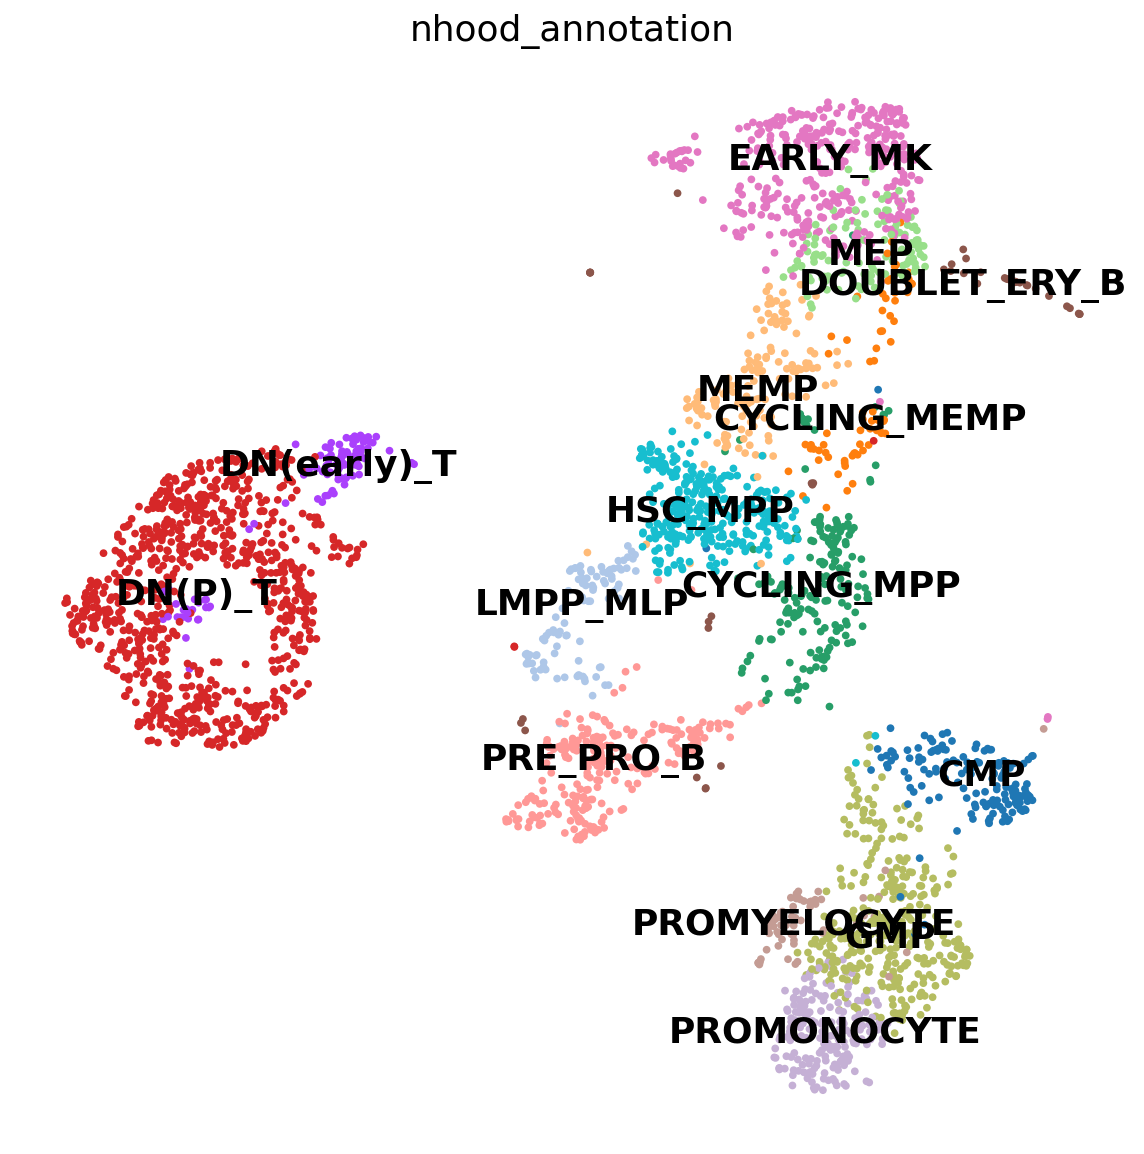

In [393]:
sc.pl.embedding(adata.uns['nhood_adata'], 'X_milo_graph', color='nhood_annotation',  size=60, frameon=False, legend_loc='on data'
#                         title=org,save='nhood_graph_{o}.pdf'.format(o=org)
                       )

In [150]:
milopy.utils.annotate_nhoods(adata, anno_col='anno_lvl_2_final_clean')

In [179]:
df = adata.uns['nhood_adata'].obs.copy()
order_prog = list(progenitor_groups_rev.keys())

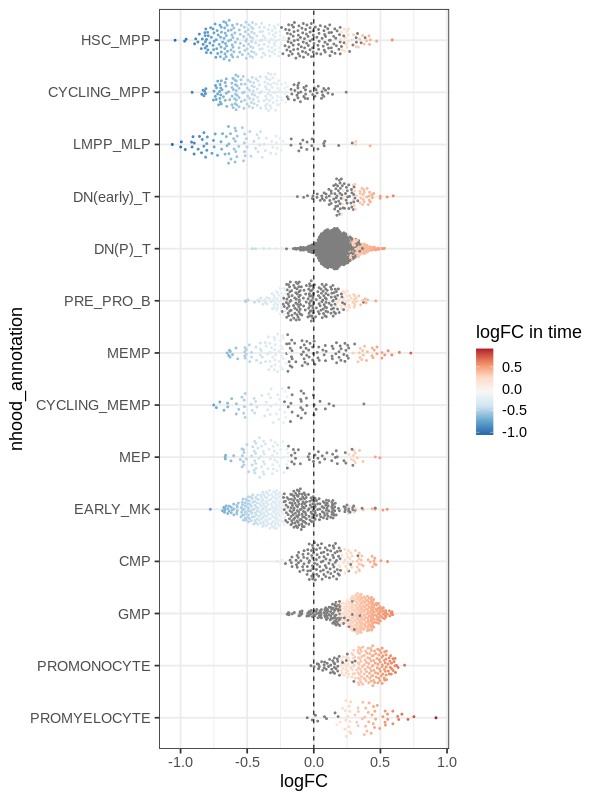

In [380]:
%%R -i df -h 800 -w 600 -i order_prog
pl1 <- df %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=rev(order_prog))) %>%
    drop_na() %>% ## NAs here are the doublets
    mutate(is_signif=ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    ggplot(aes(nhood_annotation, logFC, color=is_signif)) +
        ggbeeswarm::geom_quasirandom(scale='width', size=0.7) +
        coord_flip() +
        geom_hline(yintercept=0, linetype=2) +
        scale_color_distiller(palette='RdBu', name='logFC in time') +
        theme_bw(base_size=18)
        
pl1 

In [196]:
milo_res_age = adata.uns['nhood_adata'].obs.copy()

### DA hematopoietic VS peripheral organs

In [400]:
adata.obs['hematopoietic_organ'] = ['hema' if x in ['YS', "BM", 'LI'] else 'peri' for x in adata.obs['organ']]
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'hematopoietic_organ'])
adata.uns['nhood_adata'].var['hematopoietic_organ'] = adata.uns['nhood_adata'].var['hematopoietic_organ'].astype('category')
design = '~ method + correction_factor + hematopoietic_organ'

milo.DA_nhoods(adata, design=design)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'hematopoietic_organ' as categorical


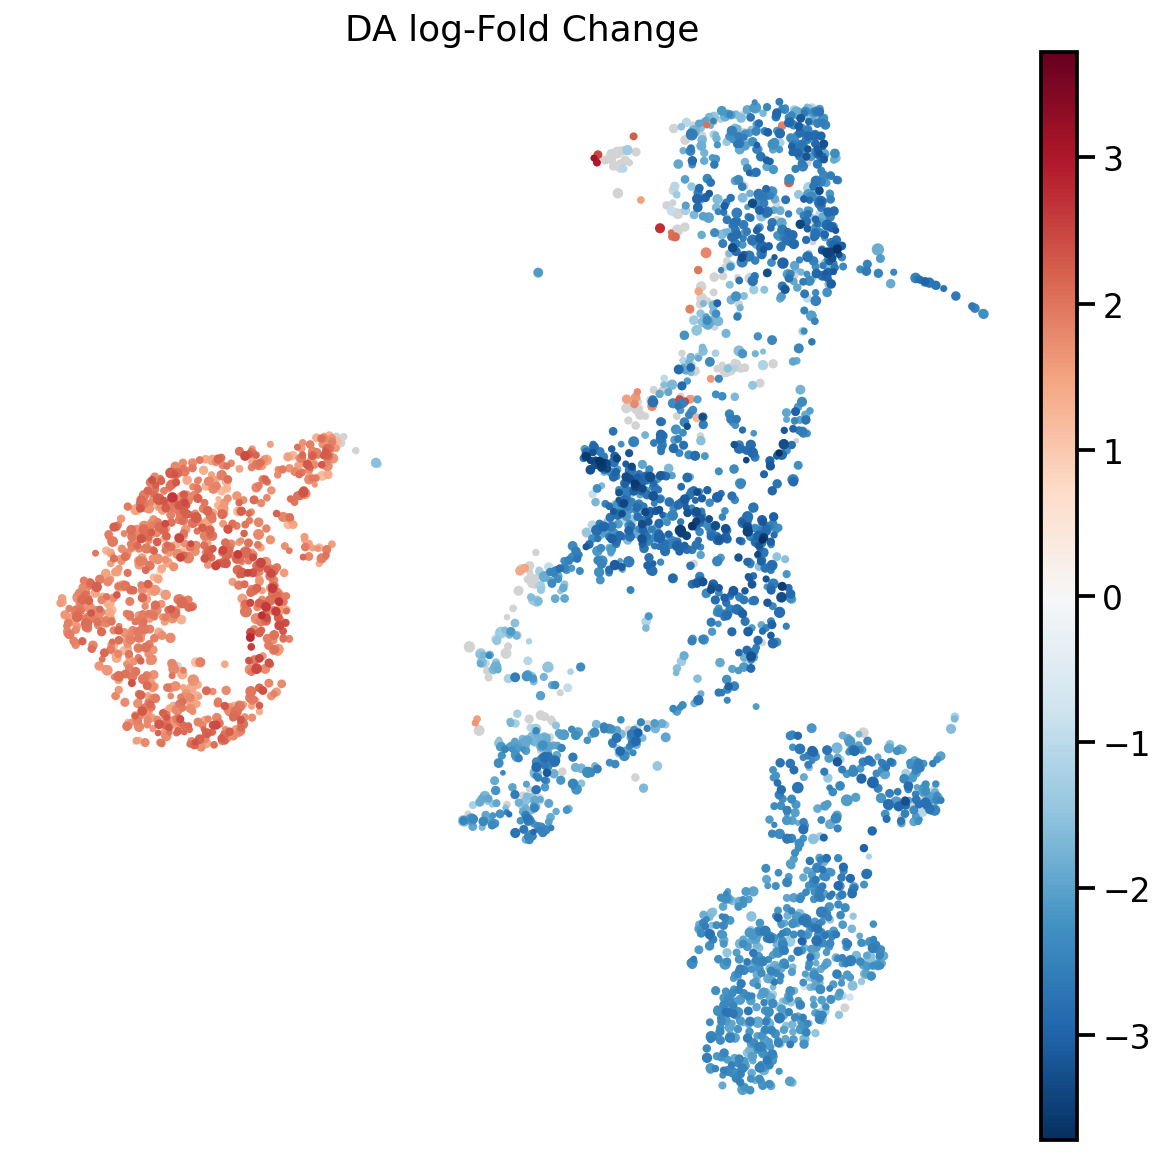

In [408]:
milopy.plot.plot_nhood_graph(adata, alpha=0.001, min_size=1)

In [406]:
df = adata.uns['nhood_adata'].obs.copy()
order_prog = list(progenitor_groups_rev.keys())

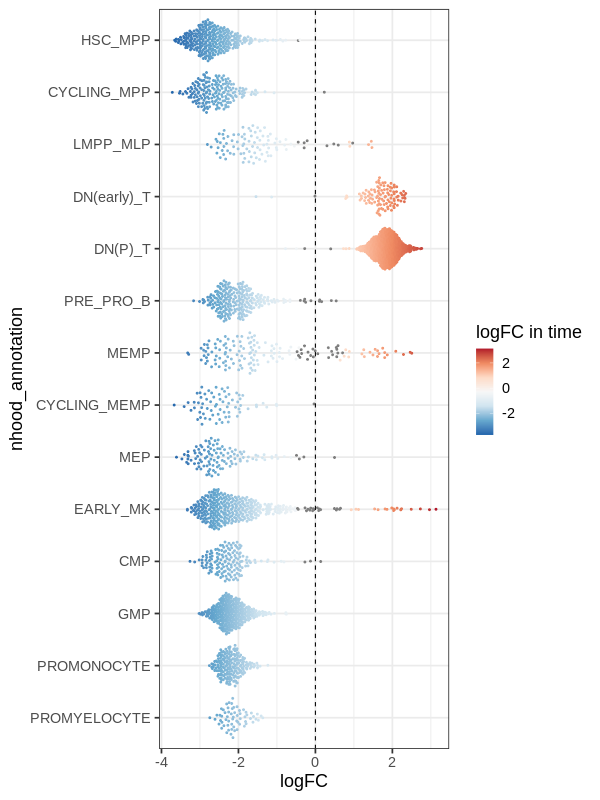

In [407]:
%%R -i df -h 800 -w 600 -i order_prog
pl1 <- df %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=rev(order_prog))) %>%
    drop_na() %>% ## NAs here are the doublets
    mutate(is_signif=ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    ggplot(aes(nhood_annotation, logFC, color=is_signif)) +
        ggbeeswarm::geom_quasirandom(scale='width', size=0.7) +
        coord_flip() +
        geom_hline(yintercept=0, linetype=2) +
        scale_color_distiller(palette='RdBu', name='logFC in time') +
        theme_bw(base_size=18)
        
pl1 

### DA across organs

In [197]:
adata.obs['organ'] = adata.obs['organ'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'organ'])
adata.uns['nhood_adata'].var['organ'] = adata.uns['nhood_adata'].var['organ'].astype('category')
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}

In [198]:
for org in all_organs:
    print(org)
    if org == adata.uns['nhood_adata'].var.organ.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.organ.cat.categories[1:].tolist()
        new_cats.append(org)
        nhood_adata.var.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design, model_contrasts='organ{o}'.format(o=org))
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


SP


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


YS


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


LI


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


TH


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


GU


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


BM


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


KI


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


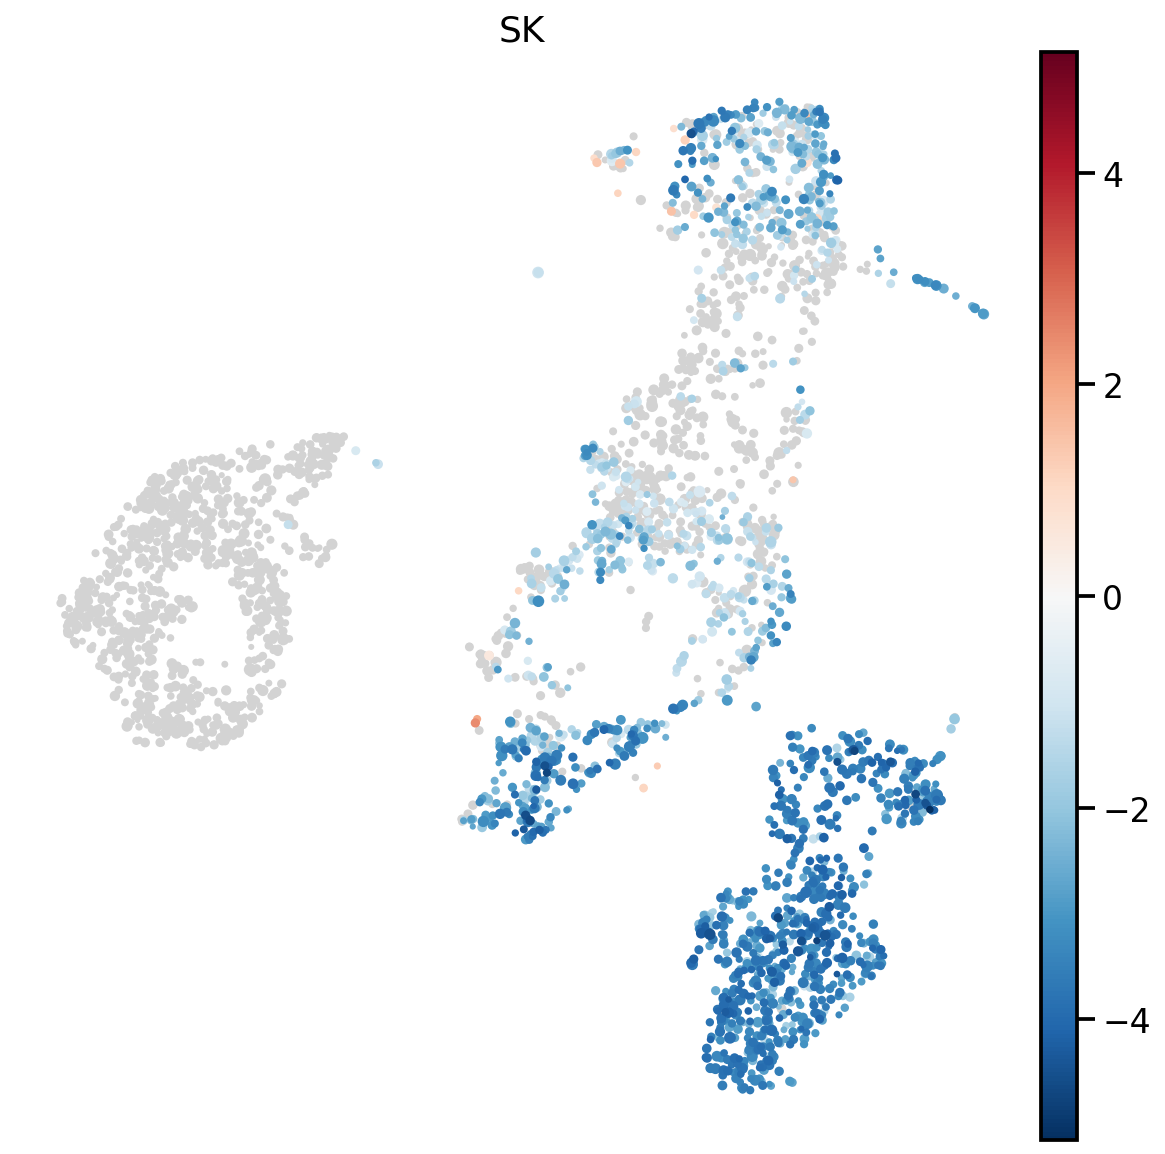

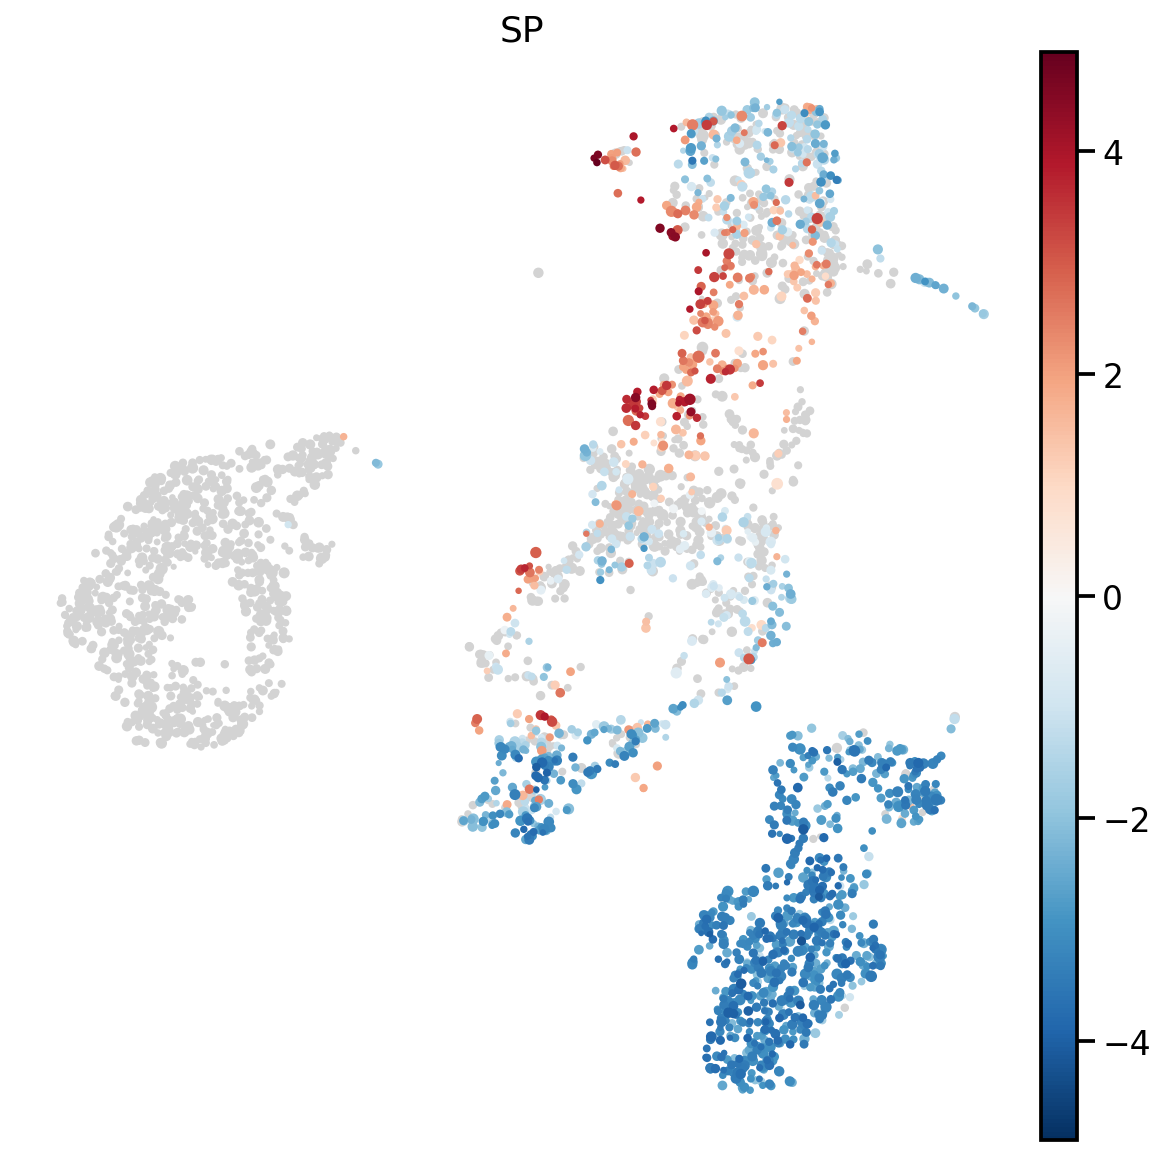

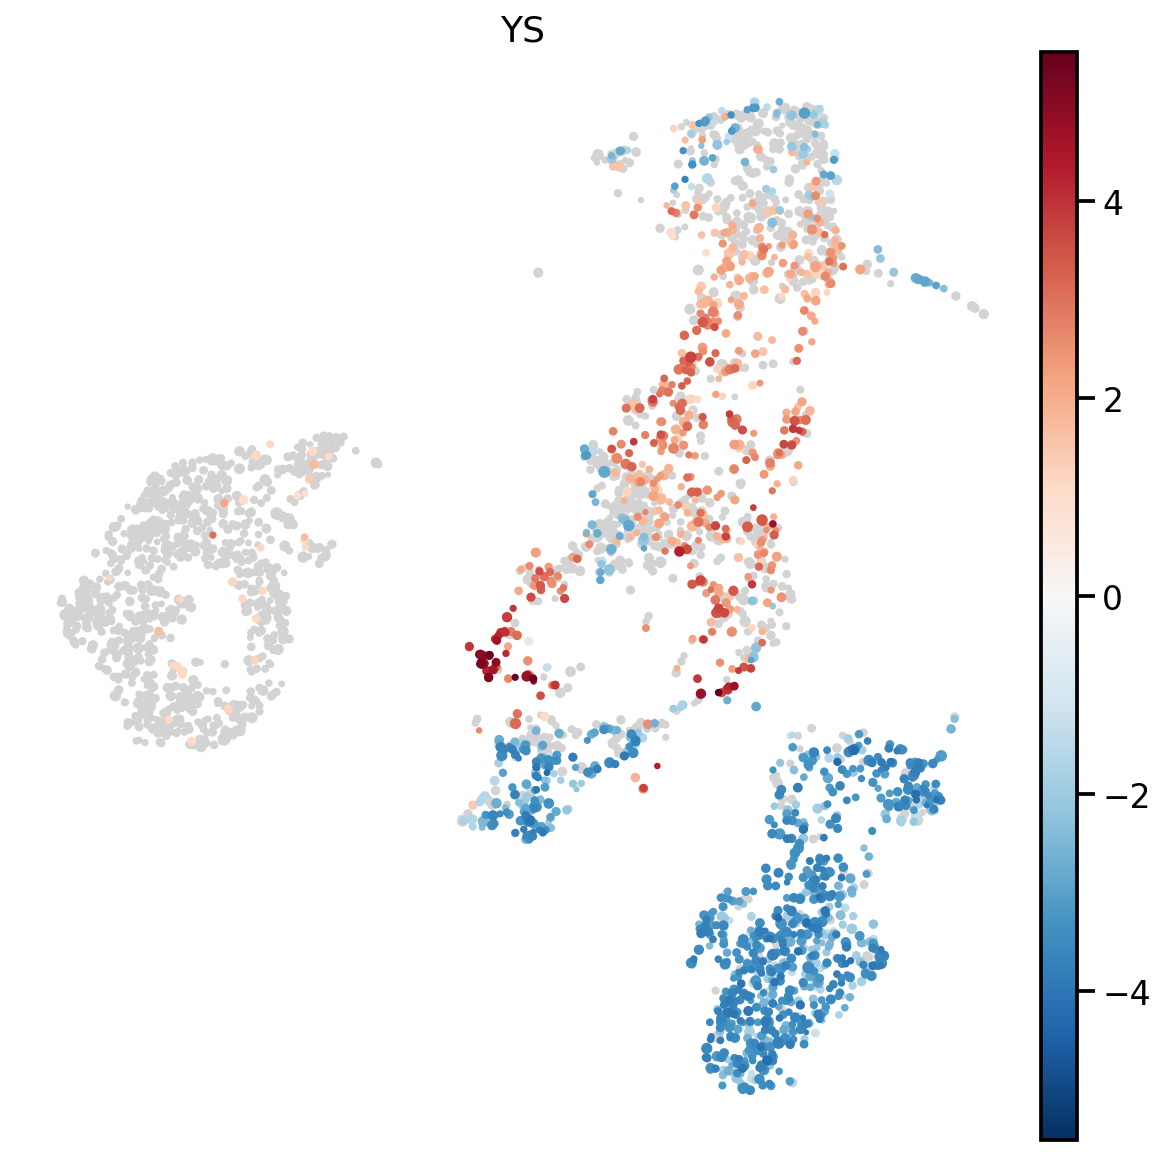

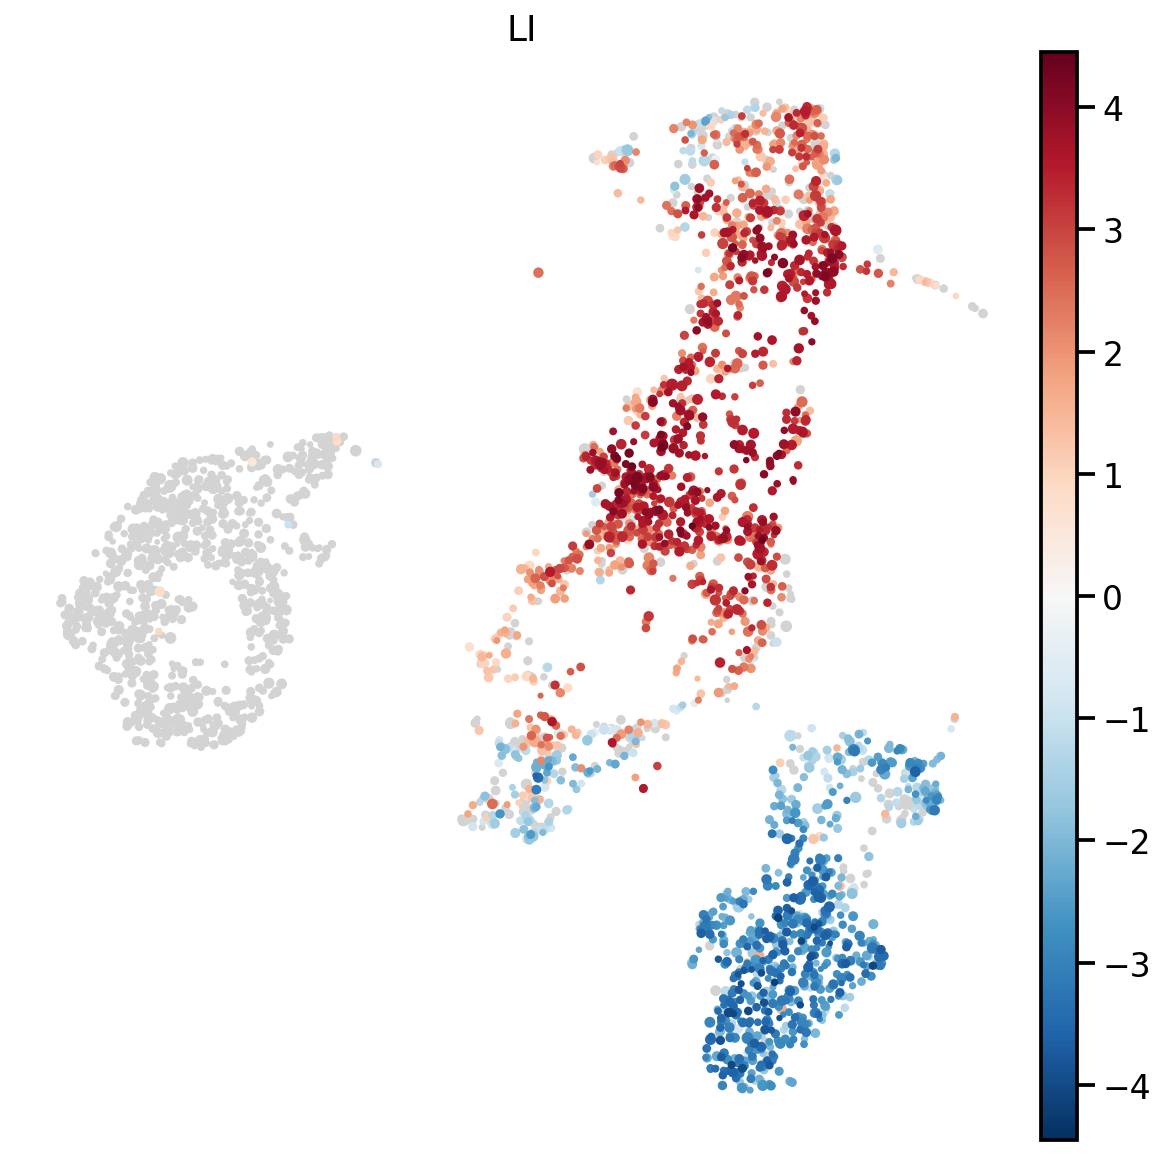

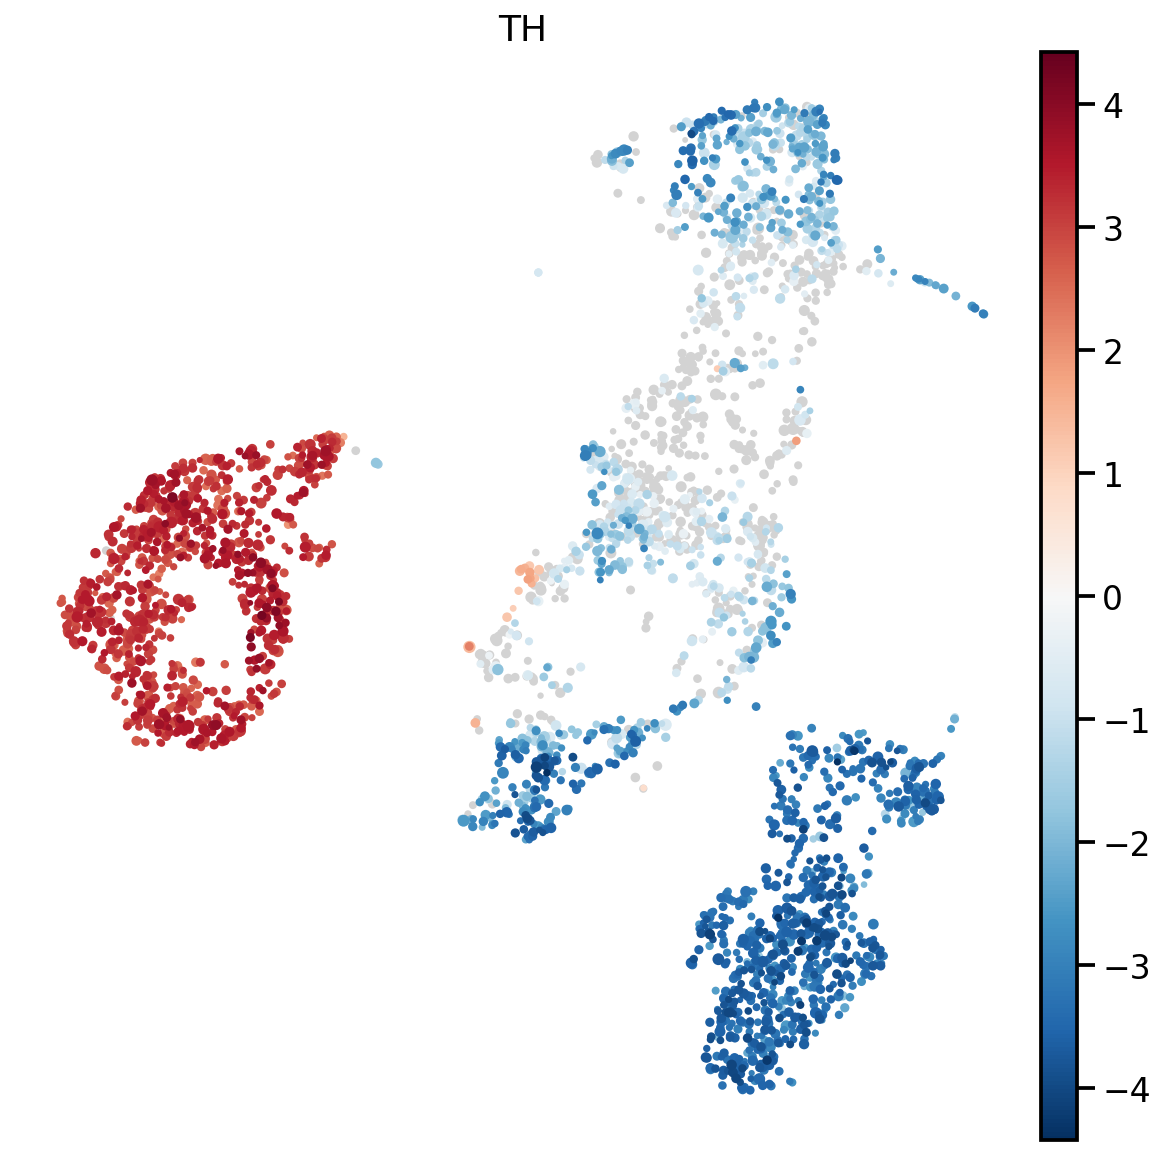

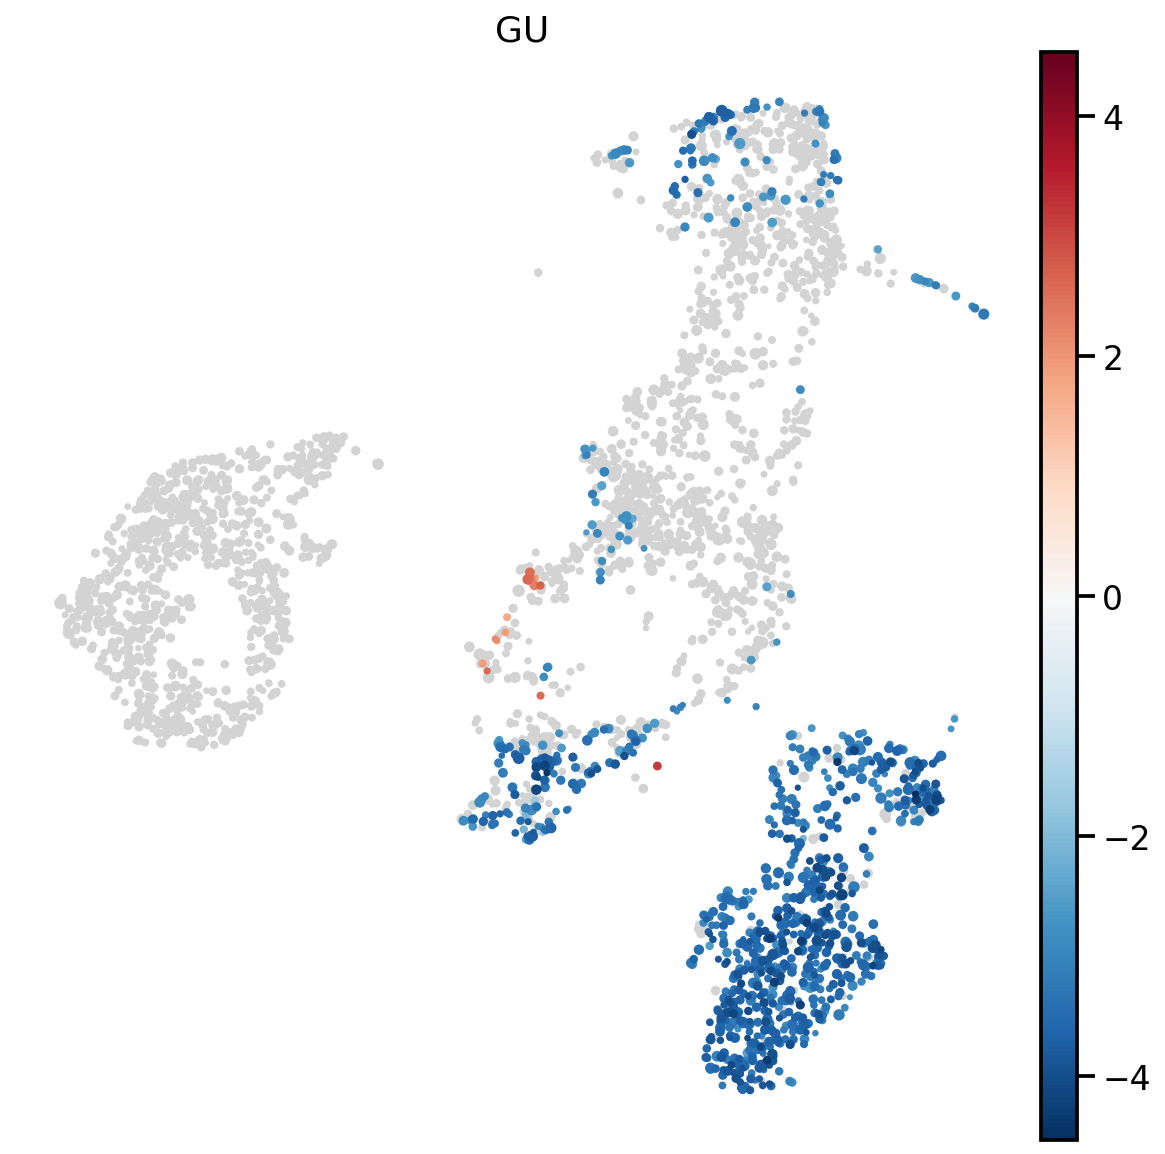

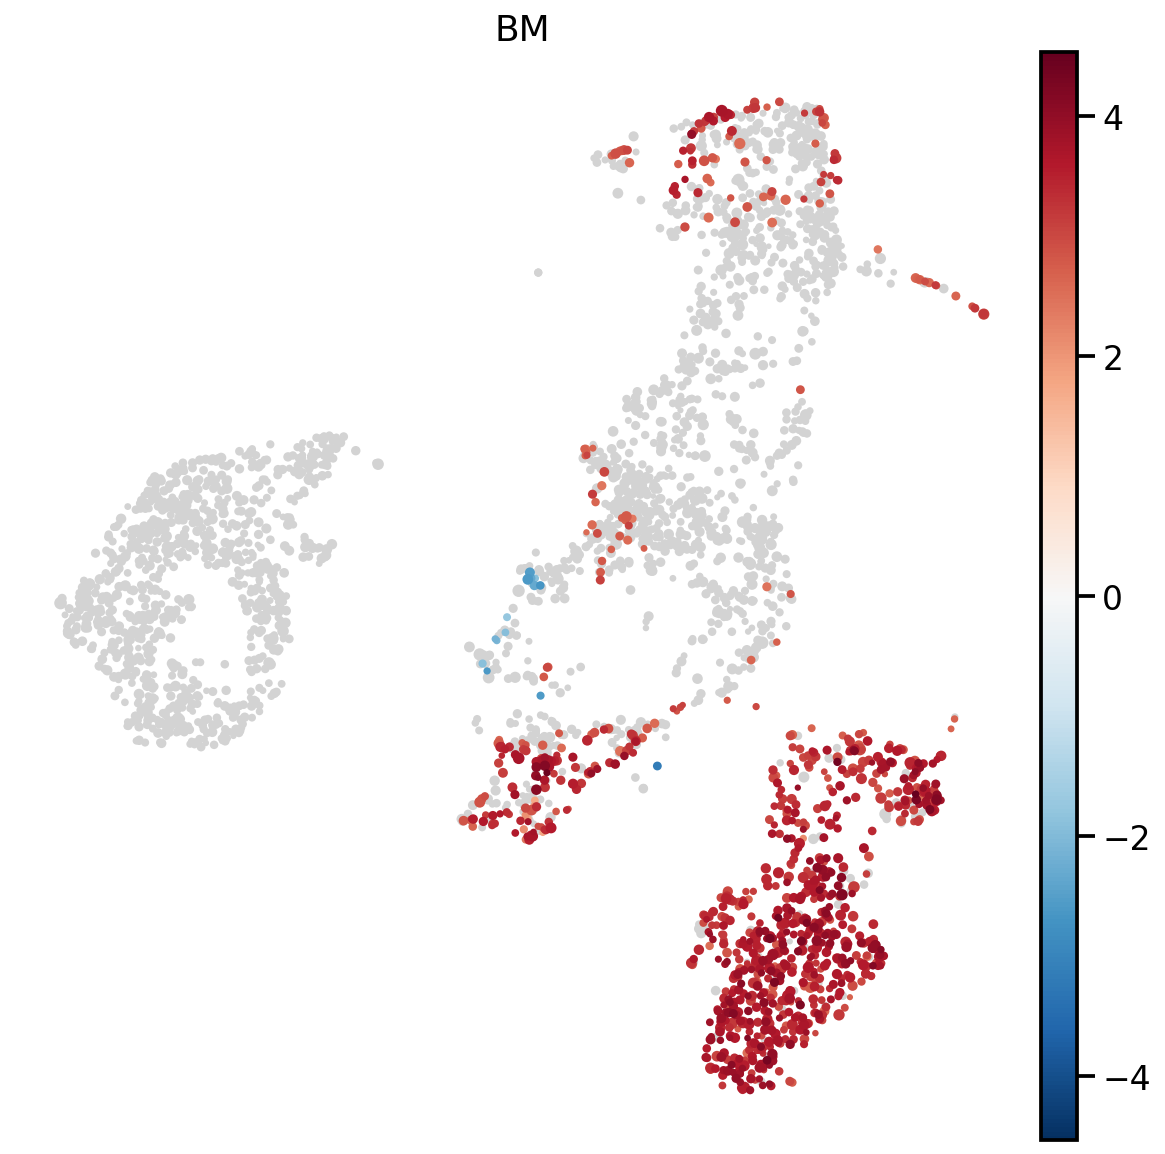

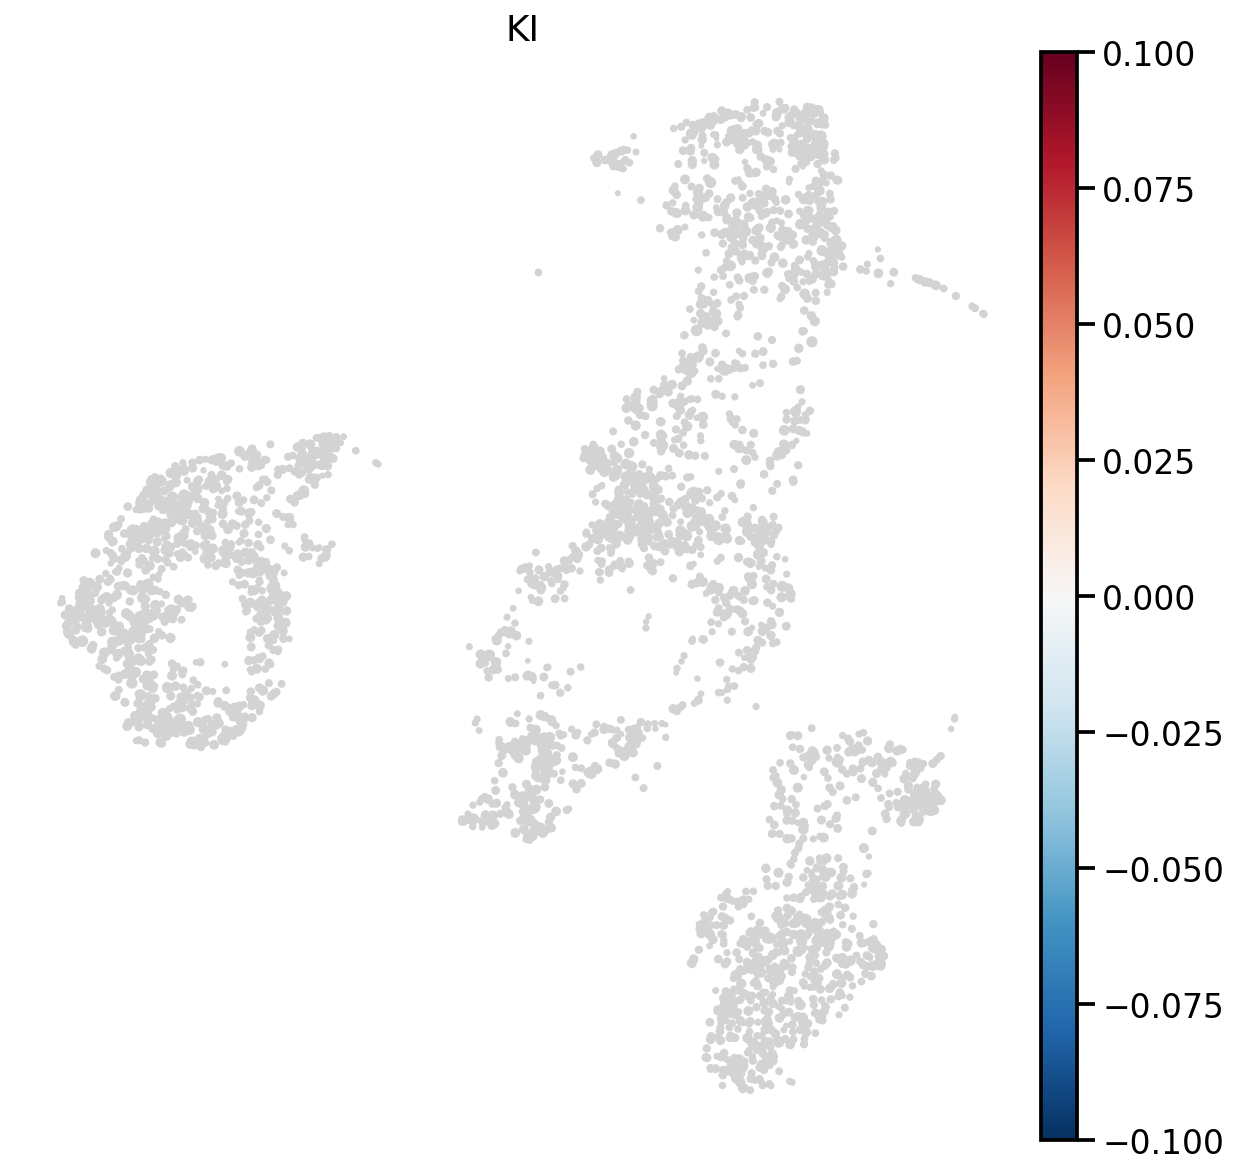

In [392]:
plt.rcParams["figure.figsize"] = [10,10]
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopy.plot.plot_nhood_graph(adata, alpha=0.1, min_size=1, title=org,
                            save="milo_nhoods_graph_{o}.png".format(o=org)
                           )

In [229]:
res_organs = pd.DataFrame()
for org in milo_res_dict.keys():
    res_organ = milo_res_dict[org].copy()
    res_organ = res_organ[['index_cell', 'nhood_annotation','SpatialFDR', 'logFC']]
    res_organ['organ'] = org
    res_organs = pd.concat([res_organs, res_organ])


In [271]:
signif_res_organs = res_organs[(res_organs.SpatialFDR < 0.1) & (res_organs.logFC > 1.5)]
signif_res_organs['is_enriched'] = 1
signif_res_organs = signif_res_organs[['index_cell', 'nhood_annotation', 'organ', 'is_enriched']].\
    pivot(index=['index_cell'], columns='organ', values='is_enriched').\
    fillna(0)
signif_res_organs = signif_res_organs[signif_res_organs.sum(1) == 1] ## restrict to organ specific
signif_res_organs['enriched_organ'] = signif_res_organs.idxmax(1).values

In [291]:
milo_res_df = milo_res_age.copy()
for org in milo_res_dict.keys():
    res_organ = milo_res_dict[org].copy()
    res_organ = res_organ[['index_cell', 'nhood_annotation','SpatialFDR', 'logFC']]
    res_organ.columns = ['index_cell', 'nhood_annotation',f'SpatialFDR_{org}', f'logFC_{org}']
    milo_res_df = pd.merge(milo_res_df, res_organ)

In [292]:
milo_res_df.index = milo_res_df['index_cell'].values
milo_res_df = pd.concat([milo_res_df, signif_res_organs], 1)

In [297]:
milo_res_df['enriched_organ'] = milo_res_df['enriched_organ'].astype("category")

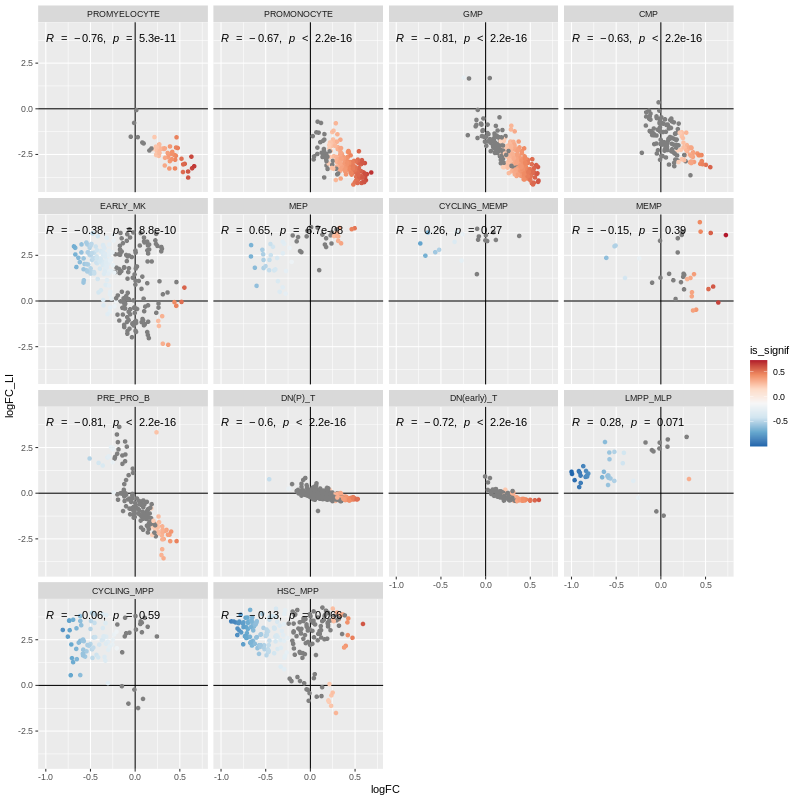

In [298]:
%%R -i milo_res_df -w 800 -h 800
milo_res_df %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=rev(order_prog))) %>%
    drop_na() %>% ## NAs here are the doublets
    mutate(is_signif=ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    ggplot(aes(logFC, logFC_LI, color=is_signif)) +
    geom_vline(xintercept=0) + geom_hline(yintercept=0) +
    geom_point() +
    scale_color_distiller(palette='RdBu') +
    facet_wrap(nhood_annotation~.) +
    ggpubr::stat_cor()

In [384]:
%%R -i milo_res_df -w 1200 -h 700
pl_df <- milo_res_df %>%
    mutate(is_signif=ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=rev(order_prog))) %>%
    filter(!is.na(nhood_annotation))  ## NAs here are the doublets
    

pl_ls <- lapply(c("YS", "LI", "BM", "SP", "TH"), function(org) {
    pl_df %>%
    mutate(color = ifelse(enriched_organ == org, org, NA)) %>%
#     arrange(color, na.last=TRUE) %>%
    ggplot(aes(nhood_annotation, logFC)) +
        geom_hline(yintercept=0, linetype=2) +
        ggbeeswarm::geom_quasirandom(
            data= . %>% arrange(color, na.last=FALSE),
            scale='width', size=0.7, color='grey') +
        ggbeeswarm::geom_quasirandom(
            data= . %>% filter(!is.na(color)),
            scale='width', size=1, aes(color=color)) +
        coord_flip() +
        scale_color_manual(values=org_colors, na.value='grey') +
#         scale_color_distiller(palette='RdBu') +
#         facet_grid(.~enriched_organ) +
        theme_bw(base_size=18) +
    ggtitle(paste(org, 'enriched')) +
    ylab("logFC in time") +
    theme(legend.position='none', legend.title=element_blank())})

pl_ls <- lapply(1:length(pl_ls), function(i) if (i > 1){pl_ls[[i]] + remove_y_axis()} else {pl_ls[[i]]} )
pl2 <- patchwork::wrap_plots(pl_ls, nrow=1) 
# as.character(unique(milo_res_df$enriched_organ))

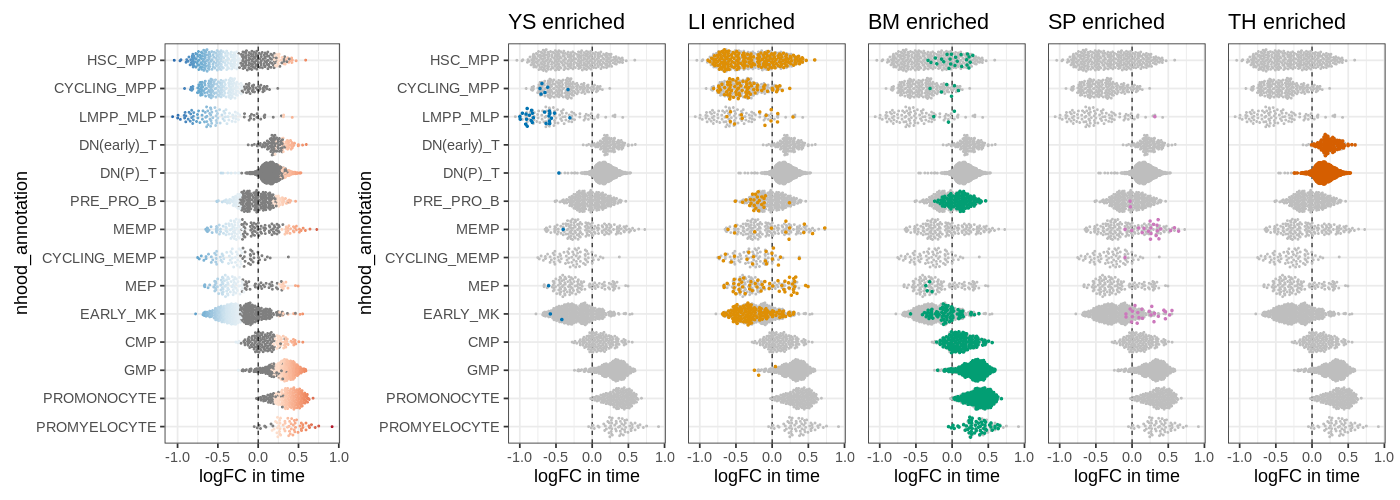

In [389]:
%%R -w 1400 -h 500

((pl1 + ylab("logFC in time") + theme(legend.position='none')) + pl2 ) + plot_layout(widths=c(1,5)) +
ggsave(paste0(figdir, 'milo_results_progenitors.pdf'), width=18, height=7) +
ggsave(paste0(figdir, 'milo_results_progenitors.png'), width=18, height=7)

## DE results - GO enrichment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

gp.__version__

names = gp.get_library_name() # default: Human

In [2]:
gene_sets=['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"]

In [24]:
p = 'B'
org = 'YS'

In [26]:
DEGs_df = pd.read_csv(f'/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_PROGENITORS_PBULK/DEGS_{p}_prog.csv', index_col=0)

In [27]:
signif_DEGs_df = DEGs_df[(DEGs_df['adj_pval'] < 0.1) & (abs(DEGs_df['lfc']) > 1)]
gene_list = signif_DEGs_df[signif_DEGs_df['test_organ'] == org].index
id_name = "DEGS_{p}_prog"
gene_list

NameError: name 'condition' is not defined

In [40]:
# run enrichr
for gene_set in gene_sets:
    # if you are only intrested in dataframe that enrichr returned, please set no_plot=True
    for anno in np.unique([x[0] for x in query_sets]):
        for condition in ['signif_early', 'signif_late']:
            id_name = "DEGS_"+condition + anno
    #         DGE = pd.read_csv(outdir+infile) 
            gene_list = all_degs_df['DEG'][(all_degs_df['annotation'] == anno) & (all_degs_df['condition'] == condition)].unique().tolist()
            # list, dataframe, series inputs are supported
            enr = gp.enrichr(gene_list=gene_list,
                             gene_sets=[gene_set],
                             organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                             description=id_name,
                             outdir='enrichr/'+id_name+'/',
                             # no_plot=True,
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            )
            # to save your figure, make sure that ``ofname`` is not Nonea
            ax=dotplot(enr.res2d, title=gene_set,cmap='RdYlBu_r',cutoff=1, top_terms=10,
                       figsize=(6,6),
                       ofname=figdir + id_name + gene_set + '.enrichr.pdf')